# PG Diploma in Machine Learning and AI
## Machine Learning - 2 : Telecom Churn Case Study
- Name: Ragesh Hajela
- Applicant ID : APFE19704533
- Roll Number  : DML1980177



- Name: Annapragada Venugopal Prasad
- Applicant ID : APFE19N01539
- Roll Number  : DML1980164

**Note: This notebook has a run time of ~43 minutes on a MacOS 2.6 GHz Intel Core i7 with 16 GB RAM 2400 MHz DDR4**

# Telecom Churn Case Study

### Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Understanding Payment Models
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

This project is based on the Indian and Southeast Asian market, where prepaid is the most common model.
In this model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

### Definition of Churn
Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

In this project, we will
- use the usage-based definition to define churn and
- we will define high-value customers based on a certain metric and predict churn only on high-value customers.

### Business Objective
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

### Understanding customer behaviour during churn
There are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase.

In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### Modelling
Suggestive steps to build the model:

- Preprocess data (convert columns to appropriate formats, handle missing values, etc.)

- Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

- Derive new features.

- Reduce the number of variables using PCA.

- Train a variety of models, tune model hyperparameters, etc. (handle class imbalance using appropriate techniques).

- Evaluate the models using appropriate evaluation metrics. Note that is is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

- Finally, choose a model based on some evaluation metric

### End Goals of the Modelling

- To predict high-valued customers who will churn.
- Identify important predictor attributes which help the business understand indicators of churn.
- Display these important predictors using plots, summary tables etc. to best convey the importance of features.
- Finally, recommend strategies to manage customer churn based on your observations.

## Step 1: Reading and Understanding the Data

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import baseline packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import importlib

# import libraries for classification modelling
from scipy import stats
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set()

In [3]:
# Read assignment data Telecom_Churn_Data.csv dataset into a telecom_data dataframe
telecom_data = pd.read_csv('Telecom_Churn_Data.csv')
print(telecom_data.shape)
telecom_data.head()

(99999, 226)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


### Helper Methods

In [4]:
# Method to get basic details about the dataset.
# <parameter> df - Pass the dataframe
# <return> Print the basic details such as shape, size, columns, data type etc.
def get_basic_details(df):
    print("Shape of dataset")
    print(df.shape)
    print("\nNumber of Observations in dataset")
    print(df.size)
    print("\nNo. of unique customers or mobile numbers in the dataset")
    print(df.mobile_number.nunique())
    print (f"\nEvery customer is represented by {df.shape[1]} features")
    print("\nBasic Info")
    print(df.info())
    print("\nColumn names")
    print(df.columns)
    print("\ndata types frequency")
    print(df.dtypes.value_counts())
    print("\nTop 3 Columns having largest number of missing values")
    print(df.isnull().sum().nlargest(3))
    print("\nTop 3 Rows having largest number of missing values")
    print(df.isnull().sum(axis=1).nlargest(3))
    print("\nNumber of total missing data in dataframe")
    print(df.isnull().sum().sum())

In [5]:
# Compute the missing value count and misisng % for each variables.
# <parameter> df - Pass the dataframe.
# <returns> return the missing values & % of misisng values for all the columns in the dataframe.
def missing_values_table_columnwise(df):
        # Get Total missing values
        mis_val = df.isnull().sum()
        
        if(mis_val.sum() == 0):
            return 'All good, no missing data found in any column.'
        if(mis_val.all()):
            return 'There are no observations at all.'
        
        # Calculate Percentage of missing values
        mis_val_percent = round(100 * df.isnull().sum() / len(df.index),2)
        
        # Create a table with the results from mis_val and mis_val_percent
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table = mis_val_table.rename(
        columns = {0 : 'missing_val_count', 1 : 'percent'})
        
       # Sort the table by percentage of missing descending
        mis_val_table = mis_val_table[
            mis_val_table.iloc[:,1] != 0].sort_values(
        'percent', ascending=False)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table.shape[0]) +
              " columns that have missing values.")
                
        # Return the dataframe with missing information
        return mis_val_table

In [6]:
# This function will return the list of columns having misisng value % greater than or equal to thresh limit
# Param1 :- df - pass the dataframe
# Param2 :- thresh - Pass the misisng value % limit
# param3 :- drop - Pass True if want to drop the columns which have more misisng value % than thresh, default False
def get_drop_columns_with_excessive_missing_value_percent(df, thresh, drop=False):
    print('Shape of dataframe columns{0}'.format(df.shape))

    # don't change passed dataframe
    df_new = df.copy()
    misisng_columns=[]
    columns_with_nan = df_new.columns[df_new.isnull().any()]
    for column in columns_with_nan:
        if 100 * df_new[column].isnull().sum() / len(df_new.index) >= thresh:
            misisng_columns.append(column)
            if drop == True:
                df_new.drop(column,1, inplace=True)
    if drop == True:
        print('Dropped {0} columns'.format(len(misisng_columns)))
        print('Shape of dataframe after droping columns{0}'.format(df_new.shape))
        return df_new
    else:
        return misisng_columns

In [7]:
# This method will get or drop the columns which have only 1 unique values in it, i.e values in all rows are same
# Takes a dataframe as input and a paramter "drop" which should be True if need to drop such column, default is False
# Returns modified dataframe if drop is True else return column list
def get_drop_column_having_one_unique_value(df, zero=False, drop=False):
    print('Shape of dataframe {0}'.format(df.shape))
    
    # don't modify passed dataframe
    df_new = df.copy() 
    col_with_only_zero=df_new.columns[(df_new == 0).all()]
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(len(col_with_only_zero)) + " columns that have only ONE distinct value i.e. 0 in all the rows.")

    if drop==True:
        df_new.drop(col_with_only_zero.values,1,inplace=True)
        print('Shape of dataframe after dropping columns.{0}'.format(df_new.shape))
        return df_new 
    else:
        return df_new.loc[:,col_with_only_zero.values]

In [8]:
# This function helps to extract out some valuable statistics from the telecom_df
def get_statistics(data_df, missing_df):
    for col in missing_df.index:
        if 'date' not in col:
            print(f'statistics for {col}')
            print(data_df[col].describe())
            print(f'99 percentile value of {col} is:', data_df[col].quantile(0.99), '\n')

In [9]:
# This function helps to impute 0 for the eligible column features
# It takes the dataframe and either takes exact cols to impute or KPI pattern to impute for all months
def apply_imputation(data_df, col_kpi_to_impute=False, exact_cols_to_impute=False, fill_mode=False):
    if col_kpi_to_impute:
        for feature in [col + month for month in ['_6','_7','_8','_9'] for col in col_kpi_to_impute]:
            data_df[feature].fillna(0, inplace=True)
        print(f'Missing values of {len(col_kpi_to_impute)*4} columns imputed with zero')
    elif exact_cols_to_impute:
        for feature in exact_cols_to_impute:
            if fill_mode:
                data_df[feature].fillna(data_df[feature].mode()[0], inplace=True)
            else:
                data_df[feature].fillna(0, inplace=True)
        if fill_mode:
            print(f'Missing values of {len(exact_cols_to_impute)} columns imputed with mode')
        else:
            print(f'Missing values of {len(exact_cols_to_impute)} columns imputed with zero')

In [10]:
# This custom function will plot the box,bar or scatter plot and will configure plot attributes as per parameters defined
# This will allow uniformity of design as well as reduce the repetition of similar code
# define plotfigure=False if using with sub plots

def plot_box_or_bar_plot(data, x, y, hue='', xlabel='', ylabel='', title='', xticks=[], yticks=[], 
                  plotfigure=True, xroataion = 0, yrotation = 0, 
                  figsize=(10,8), ylog=False, xlog=False, plot=0, 
                  ticksFont_size=12, labelsFont_size=14,
                  legend_label=[], legend_loc='upper right', 
                  legend_font=14,
                  have_legend=False,
                  legedTitle='',
                  bbox_to_anchor = (1.35, 0.85),
                  annotate = True,
                  annoteSize=12):
    
    if plotfigure :
        _ = plt.figure(figsize=figsize)
        
    # plot with hue if provided
    if len(hue) > 0 :   
        if plot == 0 :
            _ = sns.boxplot(data=data, x=x, y=y,hue=hue, palette='cool_r')
        elif plot == 1:
            splot = sns.barplot(data=data, x=x, y=y,hue=hue, palette='cool_r')
        else:
            _ = sns.scatterplot(data=data, x=x, y=y,hue=hue, palette='cool_r')
    else : 
        if plot == 0 :
            _ = sns.boxplot(data=data, x=x, y=y, palette='cool_r')
        elif plot == 1: 
            splot = sns.barplot(data=data, x=x, y=y, palette='cool_r')
        else:
            _ = sns.scatterplot(data=data, x=x, y=y, palette='cool_r')
    
    # Adding title to the plot
    if len(title) > 0:
        _ = plt.title(title,fontsize=14, color='#660055', pad=2)
        
    # Adding labels to the plot
    if len(ylabel) > 0 :     
        _ = plt.ylabel(ylabel,fontsize=labelsFont_size, color='#550055')
    if len(xlabel) > 0 : 
        _ = plt.xlabel(xlabel,fontsize=labelsFont_size, color='#550055')
   
    # Plot on log scale
    if ylog:
        _ = plt.yscale('log')
    if xlog:
        _ = plt.xscale('log') 
        
        
    # Adding ticks
    if len(xticks) == 2:
        _ = plt.xticks(xticks[0],xticks[1], size=ticksFont_size, rotation=xroataion, color='#124788')
    else :
        _ = plt.xticks(size=ticksFont_size, rotation=xroataion, color='#124788')
    if len(yticks) == 2:
        _ = plt.yticks(yticks[0],yticks[1], size=ticksFont_size, rotation=yrotation, color='#124788')
    else :
        _ = plt.yticks(size=ticksFont_size, rotation=yrotation, color='#124788')
        
    # Configure legends    
    if have_legend :
        if len(legend_label) > 0:    
            _ = plt.legend(labels=legend_label,title=legedTitle, loc=legend_loc, fontsize=legend_font, bbox_to_anchor= bbox_to_anchor)
        else :
            _ = plt.legend(title=legedTitle, loc=legend_loc, fontsize=legend_font, bbox_to_anchor=bbox_to_anchor)
            
    # Annotate the y-axis value count on top of each bar in case of bar plot
    if plot==1 & annotate: 
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.2f')+'%', (p.get_x() + p.get_width() / 2., p.get_height()), color='#124799',fontSize=annoteSize, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [11]:
# This custom function will plot the dist plot and will configure plot attributes as per parameters defined
# This will allow uniformity of design as well as reduce the repetition of similar code
# define plotfigure=False if using with sub plots

def plot_dist_plot(series,kde=True,
                   rug=False,
                   hist=True,
                   plotfigure=True,
                   bins=30, 
                   figsize=(15,6), 
                   xlabel='', 
                   ylabel='', 
                   title='',
                   labelsFont_size=14,
                   titleFont_size=14,
                   ticksFont_size=12):
    
    if plotfigure :
        _ = plt.figure(figsize=figsize)
    
    _ = sns.distplot(series,hist=hist,kde=kde,rug=rug,bins=bins)
 
    if len(title) > 0:
        _ = plt.title(title,fontsize=titleFont_size, color='#660055', pad=2)
        
    if len(ylabel) > 0 :     
        _ = plt.ylabel(ylabel,fontsize=labelsFont_size, color='#550055')
    if len(xlabel) > 0 : 
        _ = plt.xlabel(xlabel,fontsize=labelsFont_size, color='#550055')
        
    _ = plt.xticks(size=ticksFont_size, color='#124788')
    _ = plt.yticks(size=ticksFont_size, color='#124788')

In [12]:
# This custom function helps to get distplot or boxplot for multiple columns and configures plot attributes parameters
# This allows uniformity of design as well as reduce the repetition of similar code
# Default plot type is box plot and takes the target variable churn_status as x-axis by default.
def make_plot(all_cols=None,
              df=None,
              plot='box',
              x_col='churn_status',
              size=(20,17),
              plt_rows=3,
              plt_cols=4):
    if plot=='box':
        plt.figure(figsize=size)
        for col in all_cols[:-1]:
            plt.subplot(plt_rows, plt_cols, all_cols[:-1].index(col)+1)
            sns.boxplot(x=x_col,y=col,data=df)
    elif plot=='dist':
        plt.figure(figsize=size)
        features = list(df.columns)[:-1]
        for col in features:
            plt.subplot(plt_rows, plt_cols, features.index(col)+1)
            sns.distplot(df[col],hist=True,kde=True,rug=False,bins=30)

In [13]:
# This function helps to plot variation in feature KPI usage between different months of good and action phase
# It uses a line plot to demonstrate the feature KPI variations
def make_variation_plot(in_df, all_cols, variant, size=(7,4)):
    fig, ax = plt.subplots(figsize=size)
    df=in_df.groupby(['churn_status'])[all_cols].mean().T
    plt.plot(df)
    ax.set_xticklabels(['June','July','August'])
    plt.legend(['Non Churn', 'Churn'])
    plt.title(f"Average {variant} for each month w.r.t churn status", 
              loc='left', fontsize=12, fontweight=0, color='blue')
    plt.xlabel("Month")
    plt.ylabel(f"Average {variant}")

In [14]:
# This custom function will help to extract the frequency distribution of a single normalized dataframe column in a df
def get_frequency_distribution(df, colName):
    frequency_dist = round( 100 * df[colName].value_counts(True),2)
    frequency_dist = frequency_dist.to_frame('normalized_frequency_distribution').reset_index()
    frequency_dist = frequency_dist.rename(columns = {'index':colName})
    return frequency_dist

In [15]:
# This custom function will help to extract the frequency distribution of a single normalized dataframe column
# based on a groupby clause of another column of the dataframe
# Param :- df - Pass the dataframe
# Param :- groupColArr - Array of columns based on which groupby clause is performed
# Param :- colName - column name based on which frequency distribution has to be done
def get_group_frequency_dist(df, groupColArr, colName):
    group_frequency_dist_group = round(100 * df.groupby(groupColArr)[colName].value_counts(normalize=True),2)
    group_frequency_dist_df = group_frequency_dist_group.to_frame('normalized_frequency_distribution').reset_index()
    return group_frequency_dist_df

In [16]:
# This function helps to create some derived variables
# We find the mean value of few KPIs of 6th and 7th month good phase,
# and then compare with 8th month action phase to fill a comparison flag
# This helps to extract some more cumulative information from the features
# Also drops the redundant columns.
def create_derived_variables(df, feature_list=None):
    print('before shape of the dataset:', telecom_data.shape)
    print('started deriving variables')
    jun, jul, aug = '_6', '_7', '_8'
    add_count, del_count = 0, 0
    if feature_list:
        for feature in feature_list:
            to_process_cols = [feature+jun, feature+jul]
            derived_col_name_1 = 'derived_avg_' + feature + jun + jul
            df[derived_col_name_1] = df[to_process_cols].mean(axis=1)
            derived_col_name_2 = 'derived_flag_' + feature
            to_compare_col = feature + aug
            df[derived_col_name_2] = np.where((df[to_compare_col] > df[derived_col_name_1]), 0, 1)
            df.drop(to_process_cols + [to_compare_col], axis=1, inplace=True)
            add_count += 2
            del_count += 3
        print(f'{add_count} derived variables created')
        print(f'{del_count} redundant source variables dropped from the dataset')
    else:
        for col in df.columns:
            if not any(el in col for el in ['average','date','day', 'derived']):
                if jun in col:
                    col_7 = col[:-2] + jul
                    new_col = col[:-2] + '7minus6'
                    df[new_col] = df[col_7] - df[col]
                    add_count += 1
                elif aug in col:
                    col_7 = col[:-2] + jul
                    new_col = col[:-2] + '8minus7'
                    df[new_col] = df[col] - df[col_7]
                    add_count += 1
        telecom_data['date_of_last_rech_7minus6'] = (telecom_data['date_of_last_rech_7'] - 
                                                     telecom_data['date_of_last_rech_6']).dt.days
        telecom_data['date_of_last_rech_8minus7'] = (telecom_data['date_of_last_rech_8'] - 
                                                     telecom_data['date_of_last_rech_7']).dt.days
        print(f'{add_count+2} derived variables created')
    print('shape of the dataset is updated to:', telecom_data.shape)

In [17]:
# Fit a model and print some model metric on training and test data
def model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    ytrain_predictions = model.predict(X_train)
    ytrain_pred_proba = model.predict_proba(X_train)[:,1]
    print("\nModel Report\n--------------")
    print("On training data:")
    print("ROC_AUC predict score:\t\t%.4f" % metrics.roc_auc_score(y_train, ytrain_predictions))
    print("Recall/Sensitivity score:\t%.4f" % metrics.recall_score(y_train, ytrain_predictions))
    print("ROC/AUC predict_proba score:\t%.4f\n" % metrics.roc_auc_score(y_train, ytrain_pred_proba))
    
    ytest_predictions = model.predict(X_test)
    ytest_pred_proba = model.predict_proba(X_test)[:,1]
    print("On test data:")
    print("ROC_AUC predict score:\t\t%.4f" % metrics.roc_auc_score(y_test, ytest_predictions))
    print("Recall/Sensitivity score:\t%.4f" % metrics.recall_score(y_test, ytest_predictions))
    print("ROC/AUC predict_proba score:\t%.4f\n" % metrics.roc_auc_score(y_test, ytest_pred_proba))

In [18]:
# Function utility to find the optimal cut off for classification of churn and non-churn status
def find_optimal_cutoff(df):
    cols = ['probability','accuracy','sensitivity','specificity']
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i] = df.churn_probability.map( lambda x: 1 if x > i else 0)
    cutoff_df = pd.DataFrame(columns = cols)

    for i in num:
        cm = metrics.confusion_matrix(df.churn_status, df[i] )
        total=sum(sum(cm))
        accuracy = (cm[0,0]+cm[1,1])/total
        sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
        specificity = cm[1,1]/(cm[1,0]+cm[1,1])
        cutoff_df.loc[i] = [i ,accuracy, sensitivity, specificity]
    print(cutoff_df)

    cutoff_df.plot.line(x=cols[0], y=cols[1:])
    plt.show()

In [19]:
# Compute model performancee metrics for actual churn status vs predicted churn status
def compute_metrics(actual_churn_status=False, predicted_churn_status=False):
    confusion = metrics.confusion_matrix(actual_churn_status, predicted_churn_status)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    # Classification report and accuracy scores
    print(f"Classification Report:\n{metrics.classification_report(actual_churn_status, predicted_churn_status)}")
    print(f"Accuracy score:\t\t{metrics.accuracy_score(actual_churn_status, predicted_churn_status)}")
    print(f"Roc_auc_score\t\t{metrics.roc_auc_score(actual_churn_status, predicted_churn_status)}")
    
    # Let's see the sensitivity of our model
    print(f"Sensitivity/Recall:\t{TP / float(TP+FN)}")
    # Let us calculate specificity
    print(f"Specificity:\t\t{TN / float(TN+FP)}")
    # Calculate false postive rate - predicting churn when customer does not have churned
    print(f"False Positive Rate:\t{FP/ float(TN+FP)}")
    # positive predictive value 
    print(f"\nPositive predictive Rate: {TP / float(TP+FP)}")
    # Negative predictive value
    print(f"Negative Predictive Rate: {TN / float(TN+ FN)}")
    # precision score value 
    print(f"Precision score value:\t{metrics.precision_score(actual_churn_status, predicted_churn_status)}")

### General Observations

In [20]:
# statistical info on telecom_data dataframe
# It has total 99999 rows and 226 columns with a mix of datatypes
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [21]:
# statistically describe telecom_data dataframe
# It provides many stat figures like mean, median etc. for all the quantitative columns of the dataframe
telecom_data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,...,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,...,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,7.380000,...,0.000000,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,34.310000,...,0.000000,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,118.740000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,49.000000,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000


In [22]:
# We have 99999 rows and 226 columns
# There are total 3594931 misisng data in telecom_data dataset
get_basic_details(telecom_data)

Shape of dataset
(99999, 226)

Number of Observations in dataset
22599774

No. of unique customers or mobile numbers in the dataset
99999

Every customer is represented by 226 features

Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None

Column names
Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

data types frequency
float64    179
int64       35
object      12
dtype: int64

Top 3 Columns having largest number of missing values
date_of_last_rech_data_6    74846
total_rech_data_6   

## Step 2: Data Understanding and Cleaning
Analysing some data attributes and performing cleanup.

In [23]:
# Let's first drop duplicates, if any
# No duplicate rows found. shape of the dataframe remains the same
print('before shape:', telecom_data.shape)
telecom_data = telecom_data.drop_duplicates()
print('after shape:', telecom_data.shape)

before shape: (99999, 226)
after shape: (99999, 226)


In [24]:
# mobile_number: Customer phone number
# We observe that all the entries are unique for mobile_number in the dataset, so it won't provide any valuable info.
# dropping mobile_number from the dataset
print(f'shape of df is: {telecom_data.shape}')
print('no. of unique mobile number in dataset:',telecom_data['mobile_number'].nunique())
telecom_data.drop(['mobile_number'], axis=1, inplace=True)
print('dropped mobile_number')

shape of df is: (99999, 226)
no. of unique mobile number in dataset: 99999
dropped mobile_number


### Handling missing data

In [25]:
# Get the missing values count and percent per column using missing_values_table_columnwise() user defined function
# We can observe that there are 40 columns which have 50% or above mising values
# Also observe that mostly the columns having missing values are related to data.
missing_values_df = missing_values_table_columnwise(telecom_data)
missing_values_df = missing_values_df[missing_values_df['percent']>50]
print(f'There are {missing_values_df.shape[0]} columns having more than 50% missing values')
missing_values_df.sort_index()

Your selected dataframe has 225 columns.
There are 166 columns that have missing values.
There are 40 columns having more than 50% missing values


,missing_val_count,percent
arpu_2g_6,74846,74.85
arpu_2g_7,74428,74.43
arpu_2g_8,73660,73.66
arpu_2g_9,74077,74.08
arpu_3g_6,74846,74.85
arpu_3g_7,74428,74.43
arpu_3g_8,73660,73.66
arpu_3g_9,74077,74.08
av_rech_amt_data_6,74846,74.85
av_rech_amt_data_7,74428,74.43


Among these 40 features, most seem to be important KPIs for the analysis. The reason for these customer KPIs having missing values seems they didn't have any relavant value for all of the months in scope i.e. 6,7,8 and 9. We can go ahead to impute such column missing values with 0 to enable these column feattures in giving valuable insights

In [26]:
# Perform imputation of NaNs with zero for important analysis features and having no relevant KPI info
cols_to_impute = ['arpu_2g', 'arpu_3g', 'av_rech_amt_data', 'count_rech_2g', 'count_rech_3g',
                  'fb_user', 'max_rech_data', 'night_pck_user', 'total_rech_data']
apply_imputation(telecom_data, cols_to_impute)

Missing values of 36 columns imputed with zero


In [27]:
# Again get the missing values count and percent per column
# We can observe that there are 4 more columns which have 50% or above mising values
missing_values_df = missing_values_table_columnwise(telecom_data)
missing_values_df = missing_values_df[missing_values_df['percent']>50]
print(f'There are {missing_values_df.shape[0]} columns having more than 50% missing values')
missing_values_df.sort_index()

Your selected dataframe has 225 columns.
There are 130 columns that have missing values.
There are 4 columns having more than 50% missing values


,missing_val_count,percent
date_of_last_rech_data_6,74846,74.85
date_of_last_rech_data_7,74428,74.43
date_of_last_rech_data_8,73660,73.66
date_of_last_rech_data_9,74077,74.08


In [28]:
# We observe that now columns having high missing values are date columns, so we can drop them
# Date columns seem not to be having much importance in the analysis and imputation will be difficult
print(f'before shape of df is: {telecom_data.shape}')
telecom_data.drop(list(missing_values_df.index), axis=1, inplace=True)
print(f'after shape of df is: {telecom_data.shape}')

before shape of df is: (99999, 225)
after shape of df is: (99999, 221)


In [29]:
# Again get the missing values count and percent per column
# We can observe that there are 58 more columns which have 5% or above mising values
missing_values_df = missing_values_table_columnwise(telecom_data)
missing_values_df = missing_values_df[missing_values_df['percent']>5]
print(f'There are {missing_values_df.shape[0]} columns having more than 5% missing values')
missing_values_df.sort_index()

Your selected dataframe has 221 columns.
There are 126 columns that have missing values.
There are 58 columns having more than 5% missing values


,missing_val_count,percent
ic_others_8,5378,5.38
ic_others_9,7745,7.75
isd_ic_mou_8,5378,5.38
isd_ic_mou_9,7745,7.75
isd_og_mou_8,5378,5.38
isd_og_mou_9,7745,7.75
loc_ic_mou_8,5378,5.38
loc_ic_mou_9,7745,7.75
loc_ic_t2f_mou_8,5378,5.38
loc_ic_t2f_mou_9,7745,7.75


Looking at the above results about columns with more 5% missing values, missing percentage is same for all 9th month and 8th month KPIs. For 9th month all the columns have 7.75% of missing values, and for 8th month the same figure is 5.38%. Let's observe if for the same customer these KPIs are missing across both these months.

In [30]:
# We observe that there are 4392 customers with same missing values for few KPIs in 8th and 9th month
# Since these features are NaN across this dataset, we can impute with zero,
# anyways 9th month data have to be removed later from this analysis since that's the churn month to be predicted
tmp_df = telecom_data[telecom_data[list(missing_values_df.index)].isnull().all(axis=1)][list(missing_values_df.index)]
print('Number of customers with missing features for 8th and 9th month is:', tmp_df.shape[0])
tmp_df.head()

Number of customers with missing features for 8th and 9th month is: 4392


,loc_og_t2f_mou_9,loc_og_t2t_mou_9,std_ic_t2o_mou_9,loc_og_mou_9,roam_og_mou_9,loc_ic_t2f_mou_9,spl_ic_mou_9,std_og_t2f_mou_9,og_others_9,roam_ic_mou_9,...,offnet_mou_8,loc_ic_mou_8,roam_ic_mou_8,loc_og_t2t_mou_8,roam_og_mou_8,spl_ic_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_ic_t2m_mou_8,loc_og_t2c_mou_8
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Perform imputation of NaNs with zero for important analysis features and having no relevant KPI info
apply_imputation(telecom_data, exact_cols_to_impute=list(missing_values_df.index))

Missing values of 58 columns imputed with zero


In [32]:
# Again get the missing values count and percent per column
# We can observe that there are 60 more columns which have 2% or above mising values
missing_values_df = missing_values_table_columnwise(telecom_data)
missing_values_df = missing_values_df[missing_values_df['percent']>2]
print(f'There are {missing_values_df.shape[0]} columns having more than 2% missing values')
missing_values_df.sort_index()

Your selected dataframe has 221 columns.
There are 68 columns that have missing values.
There are 60 columns having more than 2% missing values


,missing_val_count,percent
date_of_last_rech_8,3622,3.62
date_of_last_rech_9,4760,4.76
ic_others_6,3937,3.94
ic_others_7,3859,3.86
isd_ic_mou_6,3937,3.94
isd_ic_mou_7,3859,3.86
isd_og_mou_6,3937,3.94
isd_og_mou_7,3859,3.86
loc_ic_mou_6,3937,3.94
loc_ic_mou_7,3859,3.86


In [33]:
# We observe that there are 382 customers with missing values for all above KPIs having more than 2% missing values
# Since these features are NaN across this dataset, but the customer count is low, we can drop these customers
tmp_df = telecom_data[telecom_data[list(missing_values_df.index)].isnull().all(axis=1)][list(missing_values_df.index)]
print('Number of customers with more than 2% missing values for 60 features is:', tmp_df.shape[0])
tmp_df.head()

Number of customers with more than 2% missing values for 60 features is: 382


,date_of_last_rech_9,loc_ic_t2f_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2c_mou_6,std_og_mou_6,spl_og_mou_6,og_others_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,...,loc_og_t2t_mou_7,isd_og_mou_7,std_og_mou_7,std_og_t2c_mou_7,loc_og_t2m_mou_7,loc_ic_t2t_mou_7,std_og_t2f_mou_7,std_og_t2m_mou_7,std_og_t2t_mou_7,date_of_last_rech_8
202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Although most columns are for 6th and 7th month, so to keep data qualiy high deciding not to impute but drop them
# We drop 382 customers where all the columns have NaNs having more than 2% missing values
print(f'before shape of df is: {telecom_data.shape}')
telecom_data = telecom_data[~telecom_data[list(missing_values_df.index)].isnull().all(axis=1)]
print(f'dropped {tmp_df.shape[0]} customers from the master dataset')
print(f'before shape of df is: {telecom_data.shape}')

before shape of df is: (99999, 221)
dropped 382 customers from the master dataset
before shape of df is: (99617, 221)


In [35]:
# For the remaining customers having more than 2% missing values, impute them with zero
# Perform imputation of NaNs with zero for important analysis features and having no relevant KPI info
apply_imputation(telecom_data, exact_cols_to_impute=list(missing_values_df.index))

Missing values of 60 columns imputed with zero


In [36]:
# Again get the missing values count and percent per column
# We can observe that there are 8 more columns which have any mising values
missing_values_df = missing_values_table_columnwise(telecom_data)
missing_values_df.sort_index()

Your selected dataframe has 221 columns.
There are 8 columns that have missing values.


,missing_val_count,percent
date_of_last_rech_6,1481,1.49
date_of_last_rech_7,1460,1.47
last_date_of_month_7,317,0.32
last_date_of_month_8,751,0.75
last_date_of_month_9,1296,1.30
loc_ic_t2o_mou,637,0.64
loc_og_t2o_mou,637,0.64
std_og_t2o_mou,637,0.64


In [37]:
# Checking non-date columns first on what unique values they contain
# We observe that except first two columns rest all having only one unique value across that column
# We can impute such columns with it's mode value i.e most commonly occuring value
for col in list(missing_values_df.index):
    print(col, telecom_data[col].unique())

date_of_last_rech_6 ['6/21/2014' '6/29/2014' '6/17/2014' '6/28/2014' '6/26/2014' '6/19/2014'
 '6/27/2014' '6/25/2014' '6/14/2014' '6/18/2014' '6/20/2014' '6/30/2014'
 '6/23/2014' nan '6/22/2014' '6/24/2014' '6/12/2014' '6/3/2014'
 '6/11/2014' '6/16/2014' '6/10/2014' '6/15/2014' '6/13/2014' '6/7/2014'
 '6/8/2014' '6/6/2014' '6/2/2014' '6/4/2014' '6/5/2014' '6/1/2014'
 '6/9/2014']
date_of_last_rech_7 ['7/16/2014' '7/31/2014' '7/24/2014' '7/28/2014' '7/17/2014' '7/25/2014'
 '7/23/2014' '7/5/2014' '7/10/2014' '7/22/2014' '7/30/2014' '7/3/2014'
 '7/7/2014' '7/29/2014' '7/27/2014' '7/19/2014' '7/14/2014' '7/20/2014'
 '7/4/2014' '7/12/2014' nan '7/26/2014' '7/11/2014' '7/6/2014' '7/21/2014'
 '7/13/2014' '7/15/2014' '7/18/2014' '7/9/2014' '7/2/2014' '7/8/2014'
 '7/1/2014']
last_date_of_month_9 ['9/30/2014' nan]
last_date_of_month_8 ['8/31/2014' nan]
loc_og_t2o_mou [ 0. nan]
std_og_t2o_mou [ 0. nan]
loc_ic_t2o_mou [ 0. nan]
last_date_of_month_7 ['7/31/2014' nan]


In [38]:
# For the columns having one value only we can impute with mode
# Perform imputation of NaNs with mode of column for important analysis features
apply_imputation(telecom_data, exact_cols_to_impute=list(missing_values_df.index)[2:], fill_mode=True)

Missing values of 6 columns imputed with mode


In [39]:
# Again get the missing values count and percent per column
# We can observe that there are 8 more columns which have any mising values
missing_values_df = missing_values_table_columnwise(telecom_data)
missing_values_df.sort_index()

Your selected dataframe has 221 columns.
There are 2 columns that have missing values.


,missing_val_count,percent
date_of_last_rech_6,1481,1.49
date_of_last_rech_7,1460,1.47


In [40]:
# We observe that there are 112 customers with missing values for all above KPIs having any missing values
# Since these features are NaN in this dataset, we can try to impute them with last date of the month
# This is an approximation that last date of recharge for 6th and 7th month will be 6/30/2014 and 7/31/2014
# This is because we observe in the unique values list the existing data is for 2014 year
tmp_df = telecom_data[telecom_data[list(missing_values_df.index)].isnull().all(axis=1)][list(missing_values_df.index)]
print('Number of customers with missing values for two date features is:', tmp_df.shape[0])
tmp_df.head()

Number of customers with missing values for two date features is: 112


,date_of_last_rech_6,date_of_last_rech_7
232,NaN,NaN
279,NaN,NaN
1189,NaN,NaN
2104,NaN,NaN
3892,NaN,NaN


In [41]:
# Impute last date of month in these date columns and check the remaining missing values in the dataset
# We observe that there are no more missing values in the master dataset
telecom_data['date_of_last_rech_6'].fillna('6/30/2014', inplace=True)
telecom_data['date_of_last_rech_7'].fillna('7/31/2014', inplace=True)
missing_values_df = missing_values_table_columnwise(telecom_data)
missing_values_df

'All good, no missing data found in any column.'

In [42]:
# Get columns which have just ONE distinct values in all the rows. This would help to cleanup the master dataframe.
# This uses the custom built utility function get_drop_column_having_one_unique_value()
# Applying this function we don't find any columns with only ONE distinct value, it's good for data quality
get_drop_column_having_one_unique_value(telecom_data, zero=True, drop=True)

Shape of dataframe (99617, 221)
Your selected dataframe has 221 columns.
There are 11 columns that have only ONE distinct value i.e. 0 in all the rows.
Shape of dataframe after dropping columns.(99617, 210)


,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,0.00,...,0,1.0,1.0,1.0,0.0,968,30.40,0.00,101.20,3.58
1,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,...,0,0.0,1.0,1.0,0.0,1006,0.00,0.00,0.00,0.00
2,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,...,0,0.0,0.0,0.0,1.0,1103,0.00,0.00,4.17,0.00
3,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,...,0,0.0,0.0,0.0,0.0,2491,0.00,0.00,0.00,0.00
4,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,...,0,0.0,0.0,0.0,0.0,1526,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,18.471,69.161,57.530,29.950,5.40,...,0,0.0,0.0,0.0,0.0,3199,0.00,0.00,0.00,0.00
99995,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,112.201,77.811,79.081,140.835,29.26,...,0,0.0,0.0,0.0,0.0,2052,0.00,0.00,0.00,0.00
99996,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,229.187,0.000,0.000,0.000,1.11,...,0,1.0,0.0,0.0,0.0,185,0.00,0.00,0.00,0.00
99997,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,322.991,303.386,606.817,731.010,0.00,...,0,1.0,1.0,1.0,1.0,478,1445.74,1151.03,1173.18,0.00


In [43]:
# Treat some columns which are not in standard naming convention of _6,_7,_8 and _9 for each month
# Replace them with the correct name
telecom_data.rename(columns={'jun_vbc_3g':'vbc_3g_6', 'jul_vbc_3g':'vbc_3g_7',
                             'aug_vbc_3g':'vbc_3g_8', 'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

### Filtering high value customers

Telecom industry follows a business rule of 80-20 i.e. 80% revenue is generated by 20% high value customers, so it's important to filter them and be predictive about their churn behaviour.

High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

We can calculate average recharge amount using two approaches:
1. Calculate manually for both 6th and 7th months

    Total Recharge Amount = Total Data Recharge Amount + Total Call Recharge Amount


2. Use recharge amount directly provided in the dataset using total_rech_amt_6 and total_rech_amt_7

We tried option(2) and it returns 29891 customers, so to be more closer to expected 29.9k figure, we wish to go ahead with option(1), which gave 29906 customers, to manually calculate recharge amount and filter high value customers.

Option(2): Use directly provided columns

In [44]:
# After filtering the high-value customers using option(2), we get 29891 customer rows.
# Columns used are:
# total_rech_amt_6: Total recharge amount for data + call for month 6
# total_rech_amt_7: Total recharge amount for data + call for month 7

telecom_data['average_recharge_amount'] = telecom_data[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
telecom_data[telecom_data.average_recharge_amount >= telecom_data.average_recharge_amount.quantile(0.7)].shape

(29891, 222)

Option(1): Manually computing total monthly recharge amount adding data and call recharge and then filter high value customers. This approach gives us 29906 customers

In [45]:
# After filtering the high-value customers using option(1), we get 29906 customer rows.
# Columns used are:
# total_rech_amt_6: Total recharge amount for month 6
# total_rech_amt_7: Total recharge amount for month 7
# total_rech_num_6: Total number of recharge for month 6
# total_rech_num_7: Total number of recharge for month 7
# count_rech_2g_6: Total count of 2G recharges during month 6
# count_rech_2g_7: Total count of 2G recharges during month 7
# count_rech_3g_6: Total count of 3G recharges during month 6
# count_rech_3g_7: Total count of 3G recharges during month 7

# First we get the average recharge amount for both 6th and 7th month
# And we observe that there exist lots of NaNs in the average column. This is because of division by zero.
telecom_data['av_rech_amt_6'] = round(telecom_data['total_rech_amt_6']/telecom_data['total_rech_num_6'], 2)
telecom_data['av_rech_amt_7'] = round(telecom_data['total_rech_amt_7']/telecom_data['total_rech_num_7'], 2)
print(telecom_data[['av_rech_amt_6','av_rech_amt_7']].isnull().sum())
telecom_data[['total_rech_amt_6', 'total_rech_num_6', 'av_rech_amt_6',
              'total_rech_amt_7', 'total_rech_num_7', 'av_rech_amt_7']]

av_rech_amt_6    1481
av_rech_amt_7    1460
dtype: int64


,total_rech_amt_6,total_rech_num_6,av_rech_amt_6,total_rech_amt_7,total_rech_num_7,av_rech_amt_7
0,362,4,90.5,252,3,84.00
1,74,4,18.5,384,9,42.67
2,168,5,33.6,315,4,78.75
3,230,10,23.0,310,11,28.18
4,196,5,39.2,350,6,58.33
...,...,...,...,...,...,...
99994,60,2,30.0,110,3,36.67
99995,110,5,22.0,110,3,36.67
99996,119,5,23.8,0,2,0.00
99997,381,3,127.0,358,4,89.50


In [46]:
# Apply imputation to replace NaNs with zero for the computed average recharge column
# Next, calculate the total number of data recharge by adding 2G and 3G services for both 6th and 7th months
# Then, we calculate the total data recharge amount by using average recharge amount and no.of data recharges
# Finally, we add call and data recharge amount for both months and get the total monthly recharge amounts
# Thus, we get the average recharge of both months and filter >=70% percentile to get high value customers
apply_imputation(telecom_data, exact_cols_to_impute=['av_rech_amt_6', 'av_rech_amt_7'])

telecom_data['total_num_data_rech_6'] = (telecom_data['count_rech_2g_6']+telecom_data['count_rech_3g_6']).astype(int)
telecom_data['total_num_data_rech_7'] = (telecom_data['count_rech_2g_7']+telecom_data['count_rech_3g_7']).astype(int)

telecom_data['total_rech_amt_data_6'] = telecom_data['total_num_data_rech_6']*telecom_data['av_rech_amt_data_6']
telecom_data['total_rech_amt_data_7'] = telecom_data['total_num_data_rech_7']*telecom_data['av_rech_amt_data_7']

telecom_data['total_monthly_rech_amt_6'] = telecom_data['total_rech_amt_6']+telecom_data['total_rech_amt_data_6']
telecom_data['total_monthly_rech_amt_7'] = telecom_data['total_rech_amt_7']+telecom_data['total_rech_amt_data_7']

telecom_data['average_rech_amt'] = telecom_data[['total_monthly_rech_amt_6', 'total_monthly_rech_amt_7']].mean(axis=1)
telecom_data = telecom_data[telecom_data.average_rech_amt >= telecom_data.average_rech_amt.quantile(0.7)]
print(f'Number of high value customers in the telecom dataset: {telecom_data.shape[0]}')
telecom_data.shape

Missing values of 2 columns imputed with zero
Number of high value customers in the telecom dataset: 29906


(29906, 231)

### Tag churn customers

Now let's tag the churned customers (churn=1, else 0) based on the 9th month i.e September as follows:

Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes we need to use to tag churners are:

- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [47]:
# Next, we try to identify the churn status based on the last month i.e. 9th month data as per the problem statement

# Columns used are:
# total_ic_mou_9: Total incoming calls minutes of usage (voice calls) for 9th month
# total_og_mou_9: Total outgoing calls minutes of usage (voice calls) for 9th month
# vol_2g_mb_9: Total Mobile internet usage volume (in MB) of 2G network for 9th month
# vol_3g_mb_9: Total Mobile internet usage volume (in MB) of 3G network for 9th month

telecom_data['churn_status'] = np.where(
    ((telecom_data['total_ic_mou_9'] == 0.00) & (telecom_data['total_og_mou_9'] == 0.00)) &
    ((telecom_data['vol_2g_mb_9'] == 0.00) & (telecom_data['vol_3g_mb_9'] == 0.00)), 1, 0)
print(telecom_data['churn_status'].value_counts())
print(round(telecom_data['churn_status'].value_counts(True)*100, 2))
print('\nNumber of customers tagged as churners are 2418 among total 29906 high value customers')
print('Percentage of customers tagged as churners is 8.09% whereas non churners are 91.91%')

0    27488
1     2418
Name: churn_status, dtype: int64
0    91.91
1     8.09
Name: churn_status, dtype: float64

Number of customers tagged as churners are 2418 among total 29906 high value customers
Percentage of customers tagged as churners is 8.09% whereas non churners are 91.91%


This shows that there is high class imbalance between churn and non-churn customers in the dataset based on the target variable churn status

In [48]:
# Let's drop all features related to churn phase i.e. 9th month
# 53 columns belonging to 9th month KPI and have been dropped from further analysis
print('before shape:', telecom_data.shape)
telecom_data = telecom_data[[col for col in telecom_data.columns if "_9" not in col]]
print('after shape:', telecom_data.shape)
print('number of 9th month KPI columns dropped are 53')

before shape: (29906, 232)
after shape: (29906, 178)
number of 9th month KPI columns dropped are 53


## Step 3: Visualising Data

Next step is to visualise and understand the data, few questions to be answered by this:
- General understanding of distribution of variables values,
- Identify some obvious multicollinearity between columns, and
- Find if some predictors directly have a strong association with the outcome variable

#### Feature: churn_status

   churn_status  normalized_frequency_distribution
0             0                              91.91
1             1                               8.09


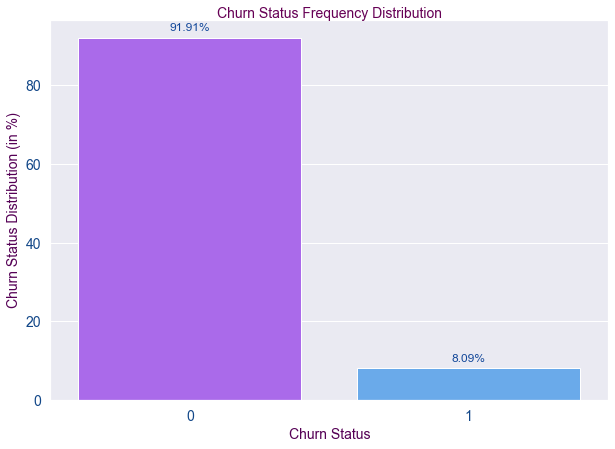

In [49]:
# churn_status: target dependent variable with two classes: churn(1) and non-churn(0)
# Get the normalized frequency distribution and plot normalized frequency distribution for churn_status
# We can see the class imbalanace that there are more customers who have not churned v/s those who have churned
# We see 91.91% have not churned and have churn_status as 0, whereas 8.09% have churned with churn_status as 1
freq_dist = get_frequency_distribution(telecom_data,'churn_status')
print(freq_dist)

plot_box_or_bar_plot(x='churn_status',
                     y='normalized_frequency_distribution',
                     data=freq_dist, 
                     xlabel='Churn Status',
                     ylabel='Churn Status Distribution (in %)',
                     title='Churn Status Frequency Distribution',
                     plot=1, 
                     figsize=(10,7),
                     ticksFont_size=14)

#### Feature: circle_id

In [50]:
# circle_id: Telecom circle area to which the customer belongs to
# We observe that circle_id is same for all the customers, so we can drop it due to lack of feature quality
print(telecom_data['circle_id'].value_counts())
print('no. of unique circle_id in dataset:',telecom_data['circle_id'].nunique())
print(f'shape of df is: {telecom_data.shape}')
telecom_data.drop(['circle_id'], axis=1, inplace=True)
print('dropped circle_id')

109    29906
Name: circle_id, dtype: int64
no. of unique circle_id in dataset: 1
shape of df is: (29906, 178)
dropped circle_id


#### Feature: AON

count    29906.000000
mean      1209.062396
std        957.342718
min        180.000000
25%        460.000000
50%        846.000000
75%       1755.000000
max       4321.000000
Name: aon, dtype: float64


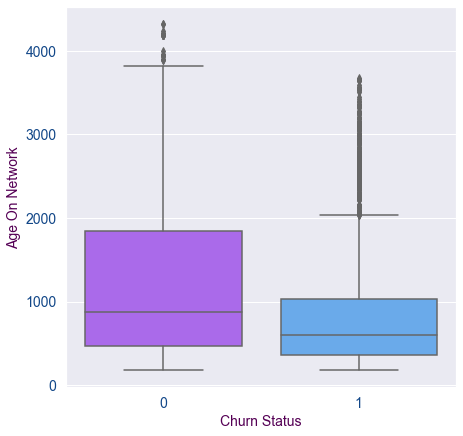

In [51]:
# aon: Age on network
# Plot the summary staistics of aon w.r.t churn status
# We observe that the people who churn have stayed less on the network and we also observe presence of outliers
print(telecom_data['aon'].describe())
plot_box_or_bar_plot(y='aon',
                     x='churn_status',
                     data=telecom_data,
                     figsize=(7,7),
                     xlabel='Churn Status',
                     ylabel='Age On Network',
                     labelsFont_size=14,
                     ticksFont_size=14)

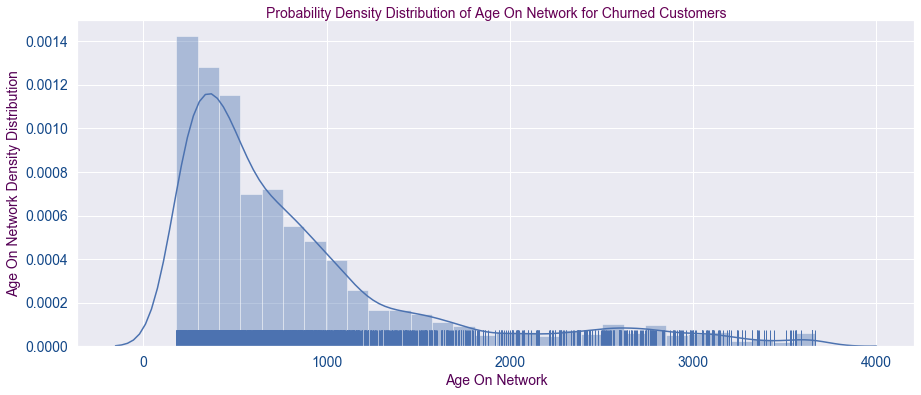

In [52]:
# Plot the probability density distribution of aon w.r.t churned customers
# We observe that mostly the customers who are not very old with the network are more prone to getting churned
plot_dist_plot(telecom_data.loc[(telecom_data['churn_status'] == 1),'aon'],
               rug=True,
               xlabel='Age On Network',
               ylabel='Age On Network Density Distribution',
               title='Probability Density Distribution of Age On Network for Churned Customers',
               ticksFont_size=14)

In [53]:
# We can create a derived variable using aon bins
# This will help us to limit aon and give more meaning with so many aon ranges available
telecom_data['aon_bin'] = pd.cut(telecom_data['aon'], range(0,telecom_data['aon'].max(),365), 
                                 labels=range(0,int(round(telecom_data['aon'].max()/365))-1)).fillna(0).astype(int)
print(telecom_data['aon_bin'].value_counts())
telecom_data[['aon', 'aon_bin']].head()

1     7965
0     5292
2     4619
3     2989
6     1904
4     1891
7     1645
8     1413
5     1165
9      523
10     500
Name: aon_bin, dtype: int64


,aon,aon_bin
0,968,2
7,802,2
8,315,0
21,720,1
23,604,1


In [54]:
# Let's also get the correlation between aon and churn status
# As per corr() We don't see much correlation between aon and churn status
telecom_data.loc[ :,['aon','churn_status']].corr()

,aon,churn_status
aon,1.000000,-0.109117
churn_status,-0.109117,1.000000


#### Feature: total_ic_mou

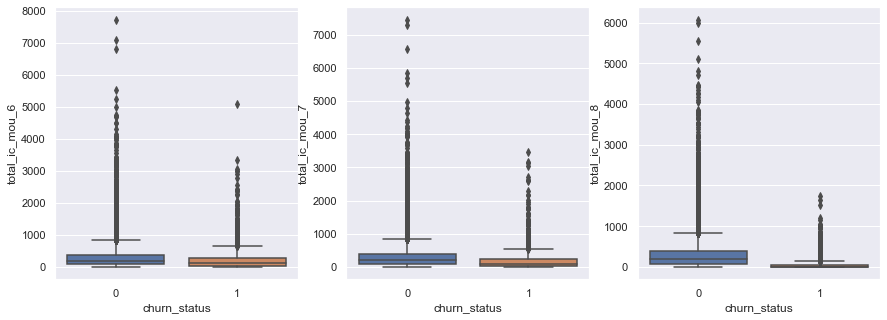

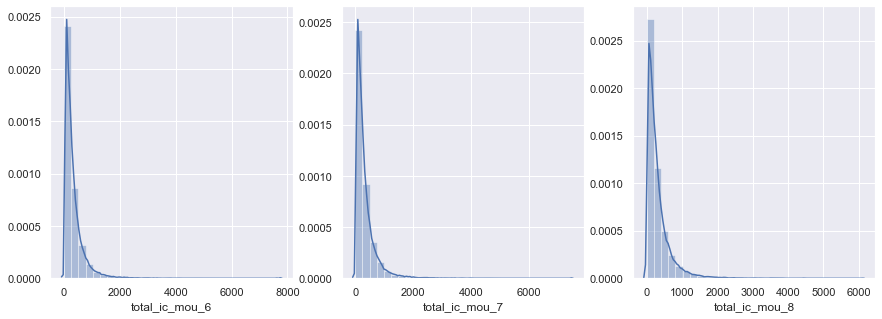

In [55]:
# total_ic_mou: Total incoming minutes of usage
# Create box plot to understand how incoming usage changes during good and action phase and relation with churn_status
# Also we observe using dict plot how the incoming usage values are distributed across every good/action phase month
to_analyse_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
churn_status,,,
0,295.401726,307.108317,299.319664
1,232.221162,183.978888,63.813168


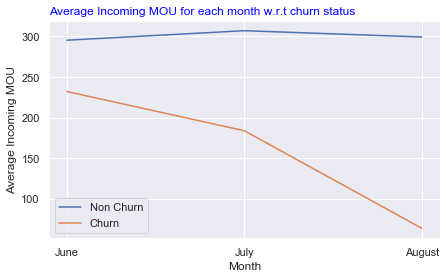

In [56]:
# Let's analyse incoming minutes of usage for each month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from June, July to August month
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'Incoming MOU')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: total_og_mou

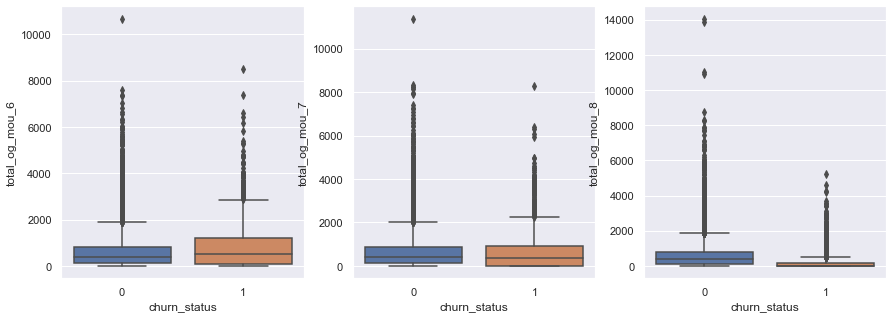

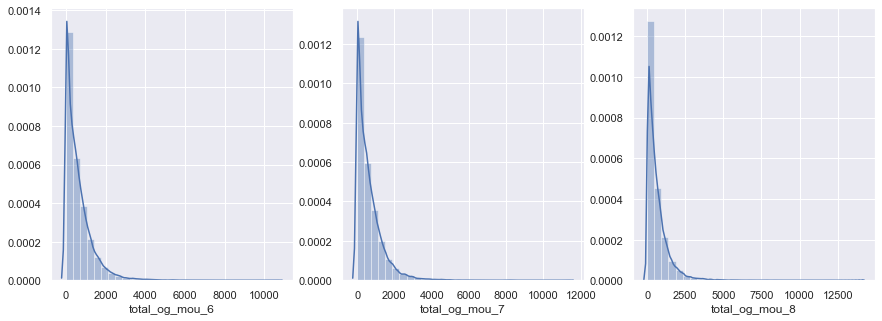

In [57]:
# total_og_mou: Total outgoing minutes of usage
# Create box plot to understand how incoming usage changes during good and action phase and relation with churn_status
# Also we observe using dict plot how the incoming usage values are distributed across every good/action phase month
to_analyse_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_status,,,
0,594.414582,629.096568,582.380539
1,795.591038,631.859433,210.659326


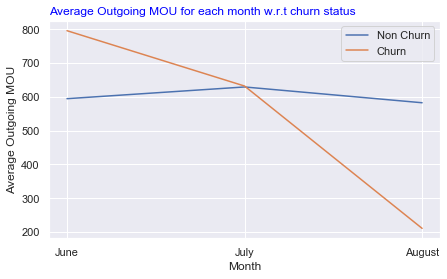

In [58]:
# Let's analyse outgoing minutes of usage for each month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from July to August month
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'Outgoing MOU')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: vol_2g_mb

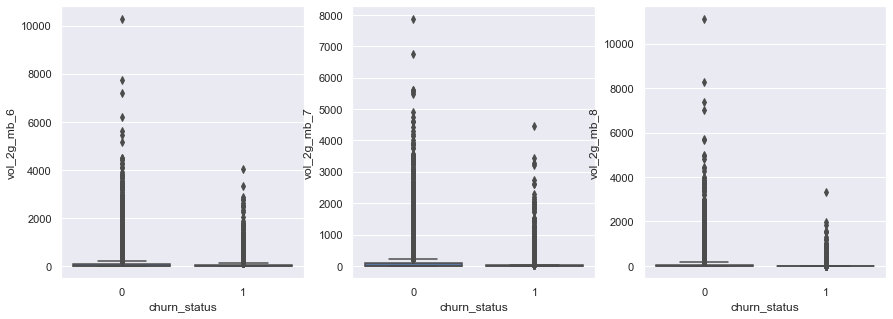

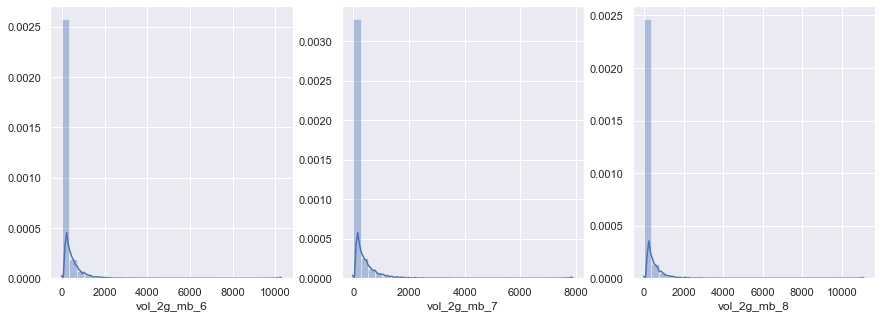

In [59]:
# vol_2g_mb_: Volume of 2G mobile internet data used in MB
# Create box plot to understand how 2G data usage changes during good and action phase and relation with churn_status
# Also we observe using dict plot how the 2G data usage values are distributed across every good/action phase month
# We observe presence of outliers
to_analyse_cols = ['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8
churn_status,,,
0,127.877567,128.280903,113.205425
1,112.801472,90.589309,23.348168


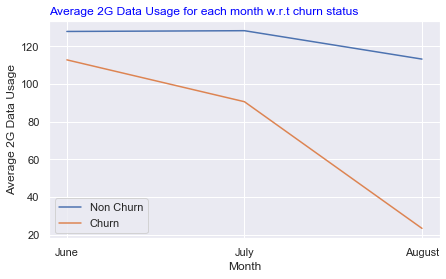

In [60]:
# Let's analyse outgoing minutes of usage for each month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from July to August month
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], '2G Data Usage')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: vol_3g_mb

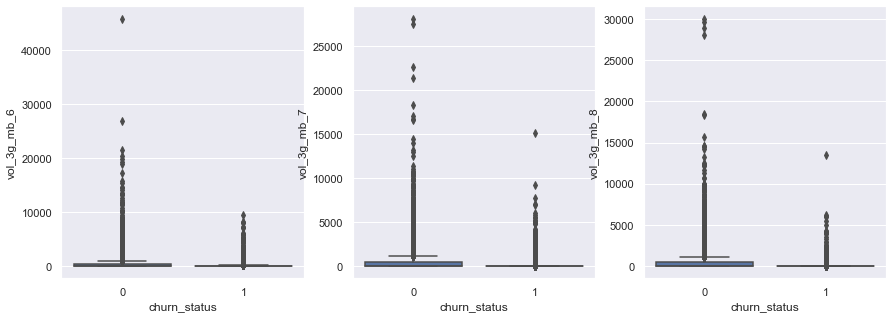

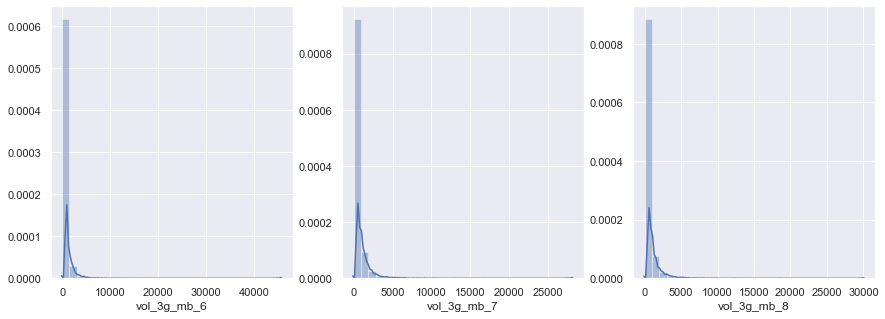

In [61]:
# vol_3g_mb_: Volume of 3G mobile internet data used in MB
# Create box plot to understand how 3G data usage changes during good and action phase and relation with churn_status
# Also we observe using dict plot how the 3G data usage values are distributed across every good/action phase month
# We observe presence of outliers
to_analyse_cols = ['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
churn_status,,,
0,350.420140,384.153945,375.438136
1,282.359723,221.094177,88.192399


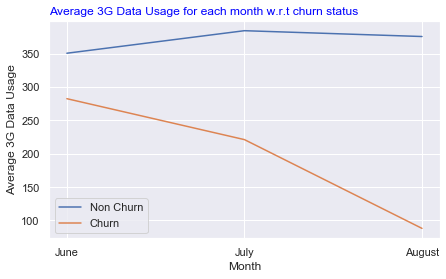

In [62]:
# Let's analyse outgoing minutes of usage for each month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from July to August month
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], '3G Data Usage')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: total_rech_amt

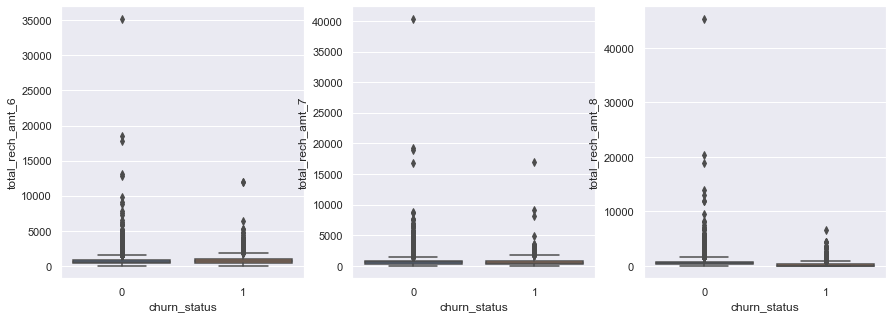

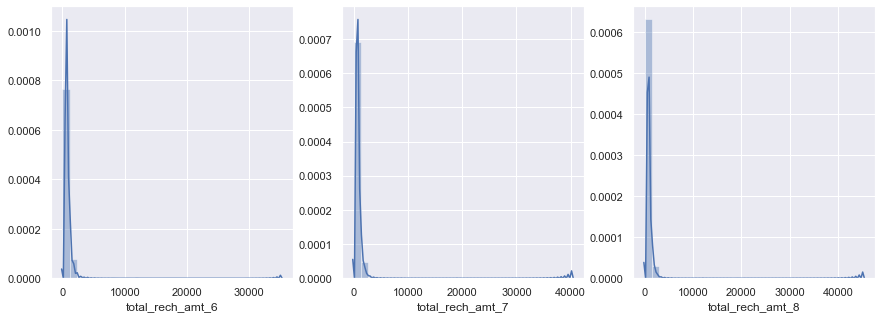

In [63]:
# total_rech_amt: Total recharge amount
# Create box plot to understand how recharge amount changes during good/action phase and relation with churn_status
# Also we observe using dict plot how recharge amounts are distributed across every good/action phase month
# We observe presence of only few outliers
to_analyse_cols = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
churn_status,,,
0,650.359357,664.195140,614.169092
1,785.353598,630.369313,255.001654


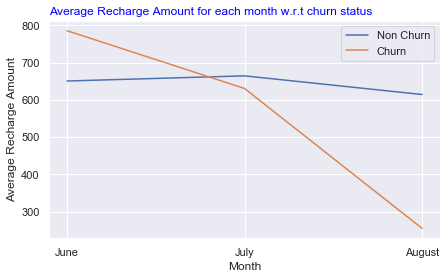

In [64]:
# Let's analyse outgoing minutes of usage for each month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from July to August month
# And for churn and non churn customers this shows drastically opposite trend, for one it increases, others decreases
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'Recharge Amount')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: max_rech_amt

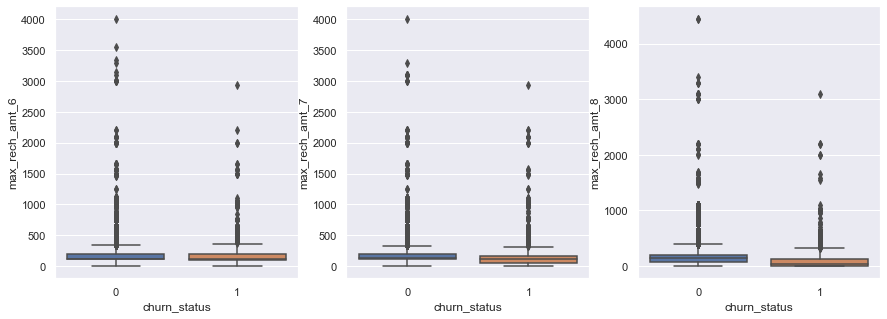

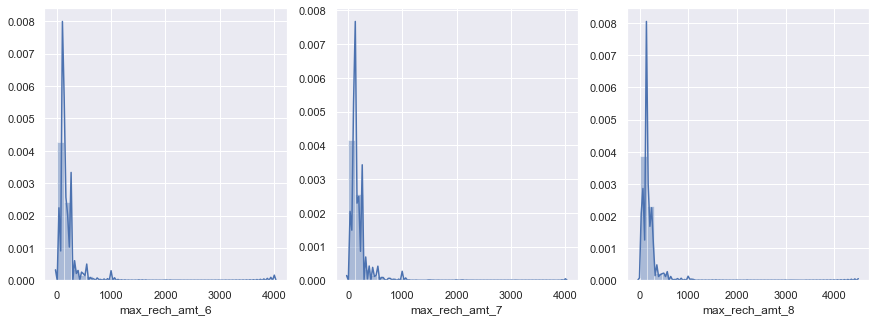

In [65]:
# max_rech_amt: Maximum recharge amount
# Create box plot to understand how recharge amount changes during good/action phase and relation with churn_status
# Also we observe using dict plot how recharge amounts are distributed across every good/action phase month
# We observe presence of only few outliers
to_analyse_cols = ['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
churn_status,,,
0,169.160943,173.437282,166.865250
1,170.930108,160.152192,86.026468


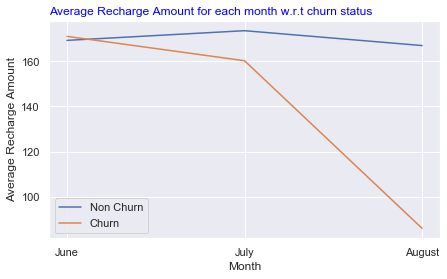

In [66]:
# Let's analyse maximum recharge amount for each month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from July to August month
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'Recharge Amount')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: arpu

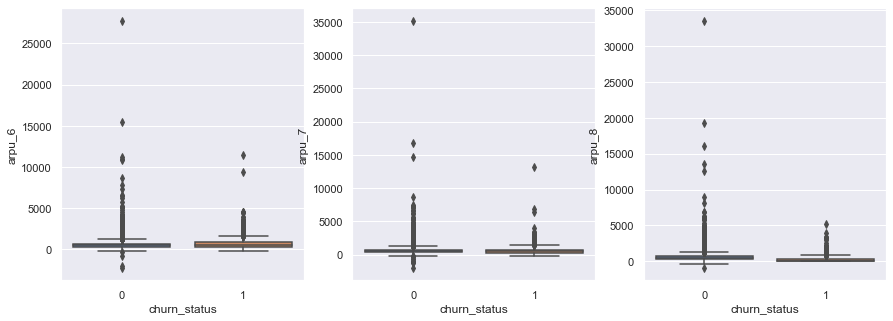

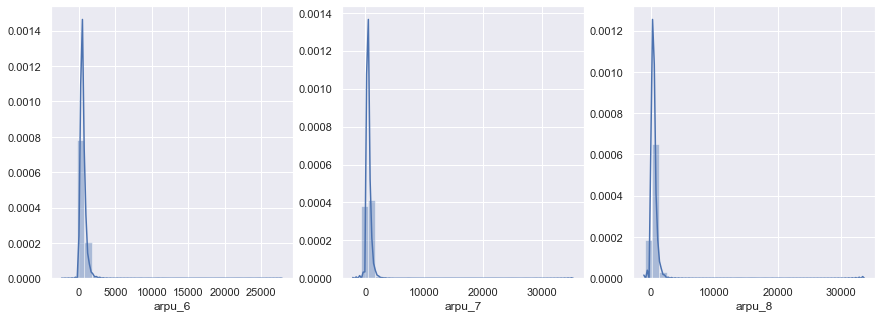

In [67]:
# arpu: Average Revenue Per User
# Create box plot to understand how arpu changes during good/action phase and relation with churn_status
# Also we observe using dict plot how arpu are distributed across every good/action phase month
# We observe presence of only few outliers
to_analyse_cols = ['arpu_6', 'arpu_7', 'arpu_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,arpu_6,arpu_7,arpu_8
churn_status,,,
0,549.843524,563.190828,533.052496
1,660.695411,543.722952,238.631887


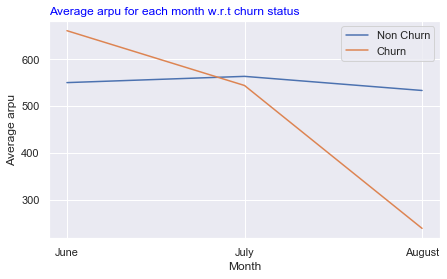

In [68]:
# Let's analyse arpu values for each month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from July to August month
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'arpu')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: roam_ic_mou

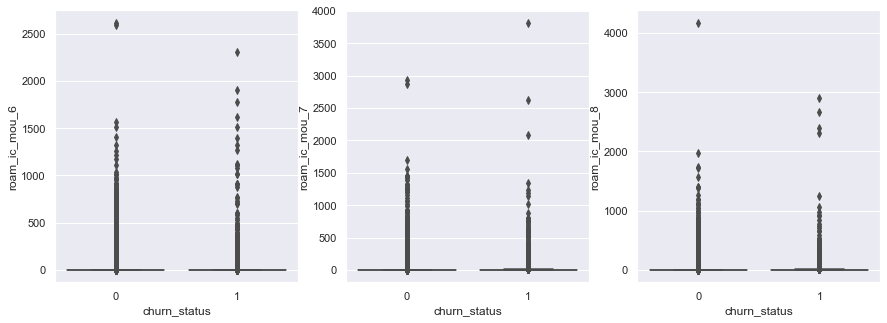

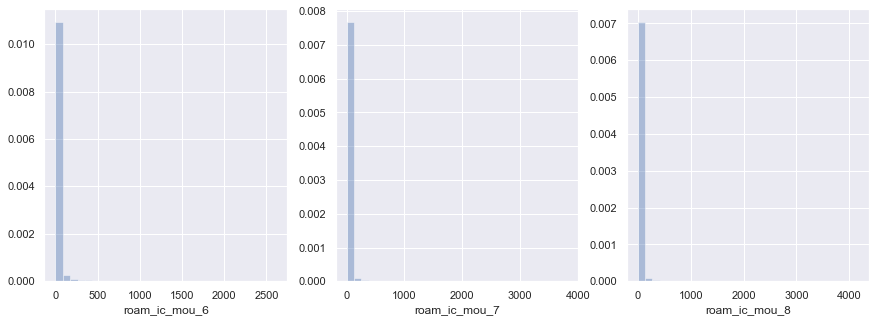

In [69]:
# roam_ic_mou: Roaming Incoming Minutes of Usage
# Create box plot to understand how roam incoming usage during good/action phase and relation with churn_status
# Also we observe using dict plot how roam incoming are distributed across every good/action phase month
# We observe presence of only few outliers
to_analyse_cols = ['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8
churn_status,,,
0,14.993915,11.124666,11.217856
1,29.217630,30.163660,27.447610


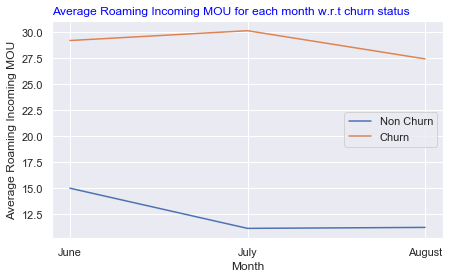

In [70]:
# Let's analyse roaming incoming values for each month of good and action phase and it's relation with churn status
# Surprisingly, we observe that for churn customers the usage is usually very high for customers who churn, compared
# to those customers to don't churn the network service provider
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'Roaming Incoming MOU')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: roam_og_mou

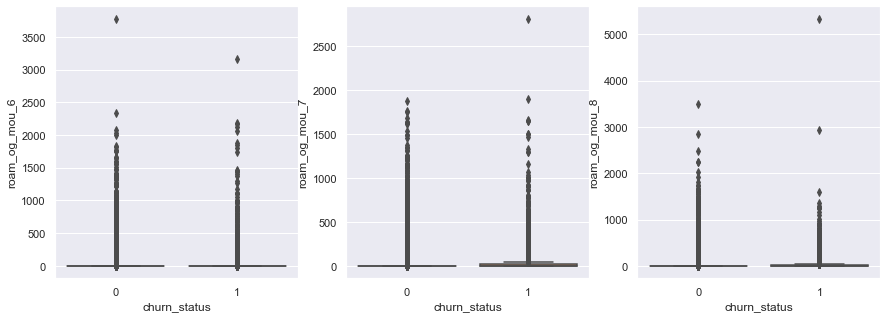

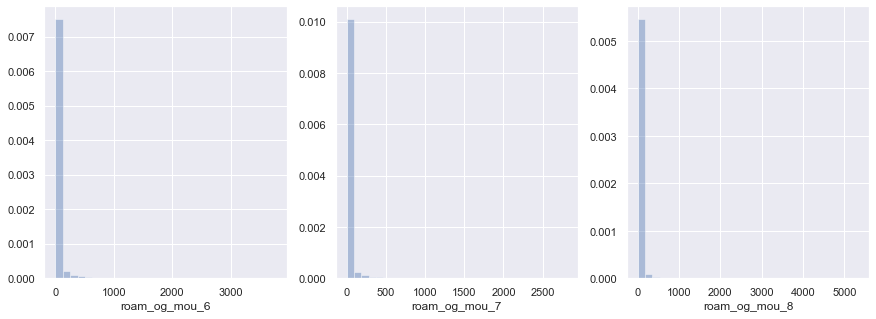

In [71]:
# roam_ic_mou: Roaming Outgoing Minutes of Usage
# Create box plot to understand how roam outgoing usage during good/action phase and relation with churn_status
# Also we observe using dict plot how roam outgoing are distributed across every good/action phase month
# We observe presence of lot of outliers
to_analyse_cols = ['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
churn_status,,,
0,24.366118,17.518635,17.798878
1,52.286526,50.488313,43.996013


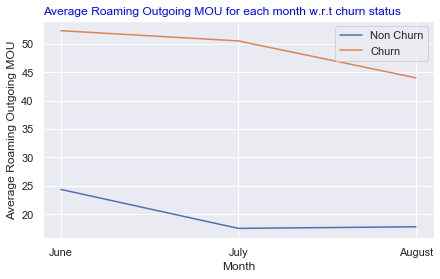

In [72]:
# Let's analyse roaming outgoing values for each month of good and action phase and it's relation with churn status
# Surprisingly, we observe that for churn customers the usage is usually very high for customers who churn, compared
# to those customers to don't churn the network service provider
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'Roaming Outgoing MOU')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: total_rech_num

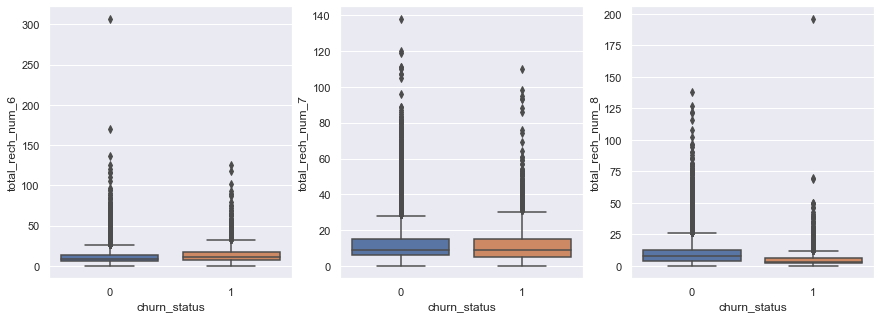

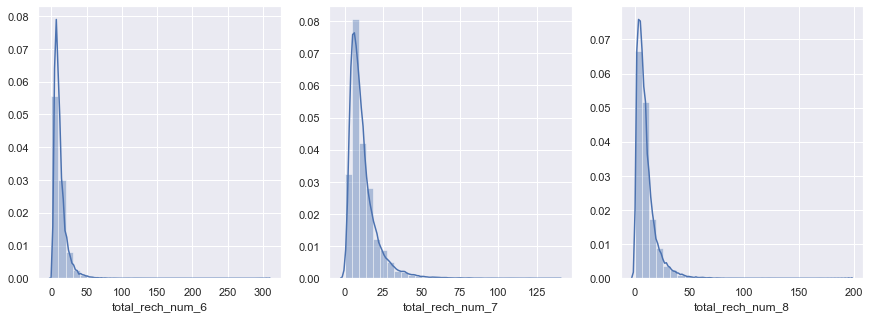

In [73]:
# total_rech_num: Total number of recharges
# Create box plot to understand how nb of recharge during good/action phase and relation with churn_status
# Also we observe using dict plot how no. of recharge are distributed across every good/action phase month
# We observe presence of lot of outliers
to_analyse_cols = ['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,total_rech_num_6,total_rech_num_7,total_rech_num_8
churn_status,,,
0,11.678223,11.756185,10.397483
1,13.918528,11.459884,5.263854


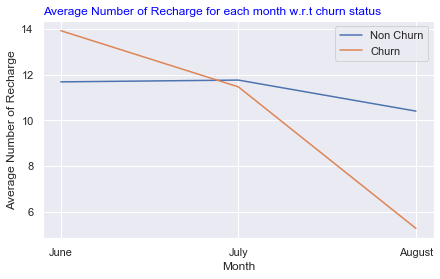

In [74]:
# Let's analyse nbvalues for each of recharge month of good and action phase and it's relation with churn status
# We observe that for churn customers the usage drops drastically from July to August month
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'Number of Recharge')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: isd_og_mou

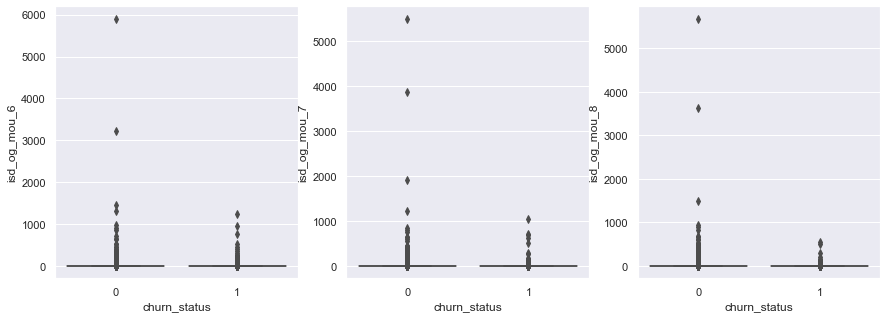

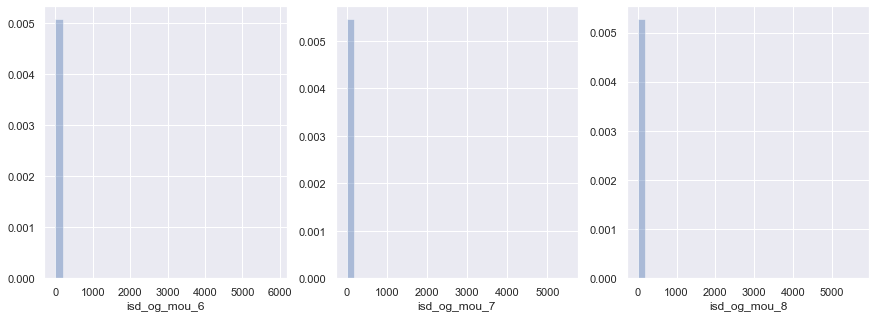

In [75]:
# isd_og_mou: International Outgoing Minutes of usage
# Create box plot to understand how ISD outgoing usage during good/action phase and relation with churn_status
# Also we observe using dict plot how ISD outgoing usage are distributed across every good/action phase month
# We observe presence of lot of outliers
to_analyse_cols = ['isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8
churn_status,,,
0,1.984966,2.020308,2.016684
1,4.374148,3.156104,1.238193


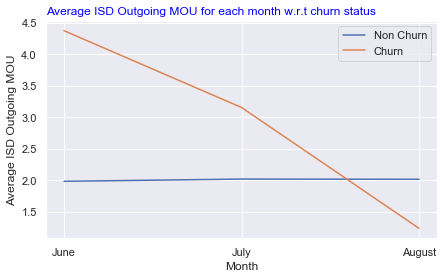

In [76]:
# Let's analyse ISD outgoing usage during month of good and action phase and it's relation with churn status
# We observe that for non churn customers usually have a fixed rate of outgoing international calls
# But for the churn customers we observe that if keeps drastically reducing every month from June to August
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'ISD Outgoing MOU')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

#### Feature: vbc_3g

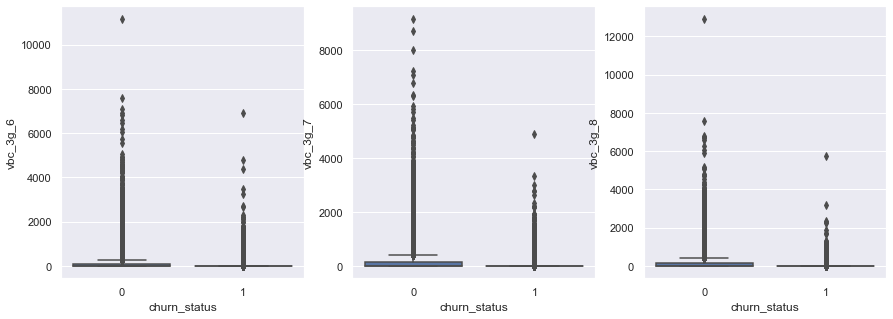

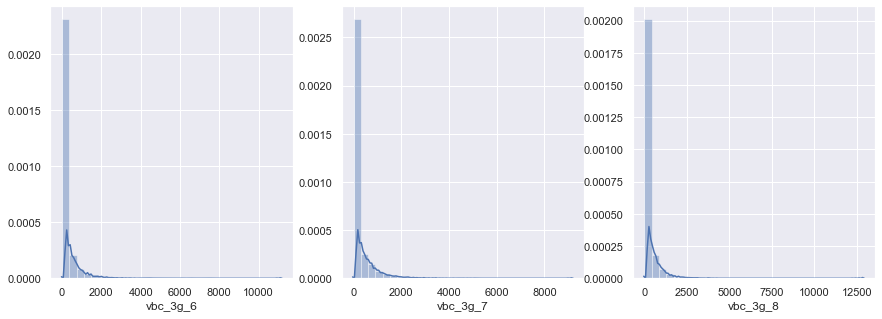

In [77]:
# vbc_3g: Volume based cost of 3G data network - when no specific scheme is not purchased and paid as per usage
# Create box plot to understand how vbc_3g usage during good/action phase and relation with churn_status
# Also we observe using dict plot how vbc_3g usage are distributed across every good/action phase month
# We observe presence of lot of outliers
to_analyse_cols = ['vbc_3g_6', 'vbc_3g_7', 'vbc_3g_8', 'churn_status']
make_plot(df=telecom_data[to_analyse_cols], all_cols=to_analyse_cols)
make_plot(df=telecom_data[to_analyse_cols], plot='dist')

,vbc_3g_6,vbc_3g_7,vbc_3g_8
churn_status,,,
0,162.660451,186.490334,180.707918
1,115.330000,96.715108,41.146737


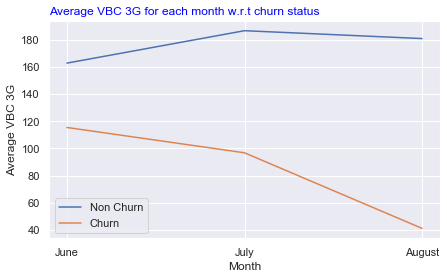

In [78]:
# Let's analyse vbc_3g usage during month of good and action phase and it's relation with churn status
# We observe that for non churn customers usually have a fixed rate of outgoing international calls
# But for the churn customers we observe that if keeps drastically reducing every month from June to August,
# whereas for non churn customers it either increases and stays constant
make_variation_plot(telecom_data[to_analyse_cols],to_analyse_cols[:-1], 'VBC 3G')
telecom_data.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

In [79]:
# Creating a backup of telecom dataset before moving ahead, it will be used at last step for recommending strategies
telecom_data_backup = telecom_data.copy()

## Step 4: Derived variables

In [80]:
# Right now the date columns are object/str fields but first standard derivation can be to derive then as date object
# columns processed are the following:
# date_of_last_rech_6: date of last recharge for June month
# date_of_last_rech_7: date of last recharge for July month
# date_of_last_rech_8: date of last recharge for August month
print('before datatype:', type(telecom_data['date_of_last_rech_6'][0]))
telecom_data['date_of_last_rech_6'] = pd.to_datetime(telecom_data['date_of_last_rech_6'])
telecom_data['date_of_last_rech_7'] = pd.to_datetime(telecom_data['date_of_last_rech_7'])
telecom_data['date_of_last_rech_8'] = pd.to_datetime(telecom_data['date_of_last_rech_8'])
print('after datatype:', type(telecom_data['date_of_last_rech_6'][0]))

before datatype: <class 'str'>
after datatype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [81]:
# Next we try to derive some more temporal features from date columns
# This may help us to derive some particular month, week etc. to find any pattern of churn predictions
telecom_data['day_of_last_rech_6'] = telecom_data['date_of_last_rech_6'].dt.day
telecom_data['dayofweek_of_last_rech_6'] = telecom_data['date_of_last_rech_6'].dt.dayofweek
telecom_data['day_of_last_rech_7'] = telecom_data['date_of_last_rech_7'].dt.day
telecom_data['dayofweek_of_last_rech_7'] = telecom_data['date_of_last_rech_7'].dt.dayofweek
telecom_data['day_of_last_rech_8'] = telecom_data['date_of_last_rech_8'].dt.day
telecom_data['dayofweek_of_last_rech_8'] = telecom_data['date_of_last_rech_8'].dt.dayofweek
print('shape of the dataset is updated to:', telecom_data.shape)

shape of the dataset is updated to: (29906, 184)


In [82]:
# Checking correlation between columns to identify any pattern among them,
# it might help in creating some derived variables and restrict to find any similar columns
corr_df = telecom_data.corr().stack().reset_index().sort_values(by = 0, ascending = False)
corr_df = corr_df[((corr_df[0] < 1) & (corr_df[0] >= 0.4)) | ((corr_df[0] <= -0.4) & (corr_df[0] > -1))]
corr_df.head()

,level_0,level_1,0
18727,count_rech_2g_8,sachet_2g_8,0.987202
23263,sachet_2g_8,count_rech_2g_8,0.987202
27525,aon_bin,aon,0.986804
25005,aon,aon_bin,0.986804
18557,count_rech_2g_7,sachet_2g_7,0.986431


In [83]:
# Check for those features which are the same KPIs for different months in good and action phase
# And they have having high correlation, so we can keep average of good phase and observe a pattern among
# good and action phase months using a comparison flag
for i in range(corr_df.shape[0]):
    temp = list(corr_df.to_numpy()[i])
    if temp[0][:-2] == temp[1][:-2]:
        print(temp)

['isd_og_mou_7', 'isd_og_mou_8', 0.9431252918689432]
['isd_og_mou_8', 'isd_og_mou_7', 0.9431252918689432]
['isd_og_mou_6', 'isd_og_mou_8', 0.9181917517014944]
['isd_og_mou_8', 'isd_og_mou_6', 0.9181917517014944]
['isd_og_mou_6', 'isd_og_mou_7', 0.9152466513147194]
['isd_og_mou_7', 'isd_og_mou_6', 0.9152466513147194]
['loc_og_mou_7', 'loc_og_mou_8', 0.8418805549216315]
['loc_og_mou_8', 'loc_og_mou_7', 0.8418805549216315]
['loc_ic_mou_7', 'loc_ic_mou_8', 0.8401407616569001]
['loc_ic_mou_8', 'loc_ic_mou_7', 0.8401407616569001]
['loc_og_t2t_mou_8', 'loc_og_t2t_mou_7', 0.833062989917951]
['loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 0.833062989917951]
['loc_og_t2m_mou_8', 'loc_og_t2m_mou_7', 0.8236438464020659]
['loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 0.8236438464020659]
['loc_ic_mou_6', 'loc_ic_mou_7', 0.8209797777226522]
['loc_ic_mou_7', 'loc_ic_mou_6', 0.8209797777226522]
['total_ic_mou_7', 'total_ic_mou_8', 0.820568375771215]
['total_ic_mou_8', 'total_ic_mou_7', 0.820568375771215]
['loc_ic_t

In [84]:
# Create bulk derived variables based on two better predictors of the churn status
# We observe that many of same KPIs have high correlation between months June, July and August
# Try to extract average of June and July month good phase and then compare with action phase
# This comparison between mean of good and action phase can determine how the change happened between these two phases
features = ['total_rech_amt', 'isd_og_mou', 'arpu_2g', 'arpu_3g', 'arpu', 'onnet_mou', 'offnet_mou', 'loc_og_t2t_mou',
            'loc_og_t2m_mou', 'loc_og_t2f_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 
            'spl_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 
            'std_ic_t2f_mou', 'isd_ic_mou', 'ic_others', 'vol_2g_mb', 'vol_3g_mb', 'vbc_3g', 'total_og_mou',
            'total_ic_mou', 'night_pck_user', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'fb_user']
create_derived_variables(telecom_data, features)
telecom_data.head()

before shape of the dataset: (29906, 184)
started deriving variables
66 derived variables created
99 redundant source variables dropped from the dataset
shape of the dataset is updated to: (29906, 151)


,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,derived_avg_monthly_2g_6_7,derived_flag_monthly_2g,derived_avg_sachet_2g_6_7,derived_flag_sachet_2g,derived_avg_monthly_3g_6_7,derived_flag_monthly_3g,derived_avg_sachet_3g_6_7,derived_flag_sachet_3g,derived_avg_fb_user_6_7,derived_flag_fb_user
0,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.00,0.00,0.00,0.00,...,0.0,1,0.0,1,1.0,1,0.0,1,1.0,1
7,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,16.23,33.49,31.64,23.74,...,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1
8,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.00,0.00,0.00,0.00,...,0.5,1,0.5,0,0.0,1,0.0,1,0.5,0
21,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.00,0.00,0.00,0.00,...,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1
23,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.00,0.00,0.00,0.00,...,0.0,1,0.0,1,1.0,1,0.0,0,0.5,0


In [85]:
# Build the comparison of KPIs as features between different months of good and action phase
# First we iterate over all eligible columns and then find difference between month 7 and month 6 in good phase
# Next we compute difference between 8th and 7th month to derive new features for trends
# Create derived features for datee difference between 7th and 6th months, and then 8th and 7th month
create_derived_variables(telecom_data)

before shape of the dataset: (29906, 151)
started deriving variables
42 derived variables created
shape of the dataset is updated to: (29906, 193)


In [86]:
# Dropping the KPIs column, including date, of good phase 6th and 7th month as we have already extracted the average
telecom_data.drop(['date_of_last_rech_6','date_of_last_rech_7', 'date_of_last_rech_8', 'last_date_of_month_6', 
                   'last_date_of_month_7', 'last_date_of_month_8'], axis=1, inplace=True)
print('shape of the dataset is updated to:', telecom_data.shape)

shape of the dataset is updated to: (29906, 187)


In [87]:
# Check and confirm that all the columns are numeric either int / float / category datatypes
telecom_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29906 entries, 0 to 99997
Data columns (total 187 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   loc_og_t2o_mou                  float64
 1   std_og_t2o_mou                  float64
 2   loc_ic_t2o_mou                  float64
 3   roam_ic_mou_6                   float64
 4   roam_ic_mou_7                   float64
 5   roam_ic_mou_8                   float64
 6   roam_og_mou_6                   float64
 7   roam_og_mou_7                   float64
 8   roam_og_mou_8                   float64
 9   loc_og_t2c_mou_6                float64
 10  loc_og_t2c_mou_7                float64
 11  loc_og_t2c_mou_8                float64
 12  loc_og_mou_6                    float64
 13  loc_og_mou_7                    float64
 14  loc_og_mou_8                    float64
 15  std_og_t2c_mou_6                float64
 16  std_og_t2c_mou_7                float64
 17  std_og_t2c_mou_8              

In [88]:
# We observe that there are no null values in the dataset and 29906 rows exist with 220 columns
print('null values in the dataset:', telecom_data.isnull().values.sum())
print('shape of the dataset is:', telecom_data.shape)

null values in the dataset: 0
shape of the dataset is: (29906, 187)


### Check for outliers
We have observed lot of outlier presence in the dataset, let's perform outlier treatment

In [89]:
# master dataset describe before treating outliers
pd.set_option('display.max_rows',300)
telecom_data.describe(percentiles=[.25,.5,.75,.9,.95,.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
loc_og_t2o_mou,29906.0,0.000000,0.000000,0.000,0.000000,0.00000,0.00000,0.0000,0.00000,0.00000,0.000
std_og_t2o_mou,29906.0,0.000000,0.000000,0.000,0.000000,0.00000,0.00000,0.0000,0.00000,0.00000,0.000
loc_ic_t2o_mou,29906.0,0.000000,0.000000,0.000,0.000000,0.00000,0.00000,0.0000,0.00000,0.00000,0.000
roam_ic_mou_6,29906.0,16.143950,76.401177,0.000,0.000000,0.00000,0.00000,27.4450,84.97250,344.66300,2613.310
roam_ic_mou_7,29906.0,12.664033,75.891527,0.000,0.000000,0.00000,0.00000,14.3200,55.75750,281.91350,3813.290
roam_ic_mou_8,29906.0,12.530086,74.235971,0.000,0.000000,0.00000,0.00000,15.0700,56.45500,283.17800,4169.810
roam_og_mou_6,29906.0,26.623576,116.354841,0.000,0.000000,0.00000,0.00000,50.5100,145.63250,531.97350,3775.110
roam_og_mou_7,29906.0,20.184344,96.206562,0.000,0.000000,0.00000,0.00000,31.1800,104.47000,438.51250,2812.040
roam_og_mou_8,29906.0,19.917004,104.879093,0.000,0.000000,0.00000,0.00000,29.0250,101.11750,427.10600,5337.040
loc_og_t2c_mou_6,29906.0,1.579472,6.312729,0.000,0.000000,0.00000,0.00000,4.2300,8.89750,24.94000,271.440


In [90]:
# Using zscores to identify and treat outliers by removing more than threshold 10 zscore
print("Shape of the dataset before removing outliers",telecom_data.shape)
cut_off=10
zscore=telecom_data.copy()
for col in zscore.columns:
    col_zscore = col + '_zscore'
    zscore[col_zscore] = (telecom_data[col] - telecom_data[col].mean())/telecom_data[col].std(ddof=0)
    zscore=zscore[~((zscore[col_zscore] > cut_off) | (zscore[col_zscore] < -cut_off))]
    zscore=zscore.drop(col_zscore, axis=1)
print("Shape of the dataset after removing outliers ",zscore.shape)
telecom_data=zscore

Shape of the dataset before removing outliers (29906, 187)
Shape of the dataset after removing outliers  (28138, 187)


In [91]:
# master dataset describe after treating outliers
pd.set_option('display.max_rows',300)
telecom_data.describe(percentiles=[.25,.5,.75,.9,.95,.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
loc_og_t2o_mou,28138.0,0.000000,0.000000,0.000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000
std_og_t2o_mou,28138.0,0.000000,0.000000,0.000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000
loc_ic_t2o_mou,28138.0,0.000000,0.000000,0.000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000
roam_ic_mou_6,28138.0,12.919277,52.260927,0.000,0.00000,0.00000,0.000000,24.46600,73.91000,278.130100,771.540
roam_ic_mou_7,28138.0,9.052835,42.463386,0.000,0.00000,0.00000,0.000000,12.28000,47.22500,209.914100,711.110
roam_ic_mou_8,28138.0,9.263560,42.649867,0.000,0.00000,0.00000,0.000000,13.16600,47.34000,216.911500,749.260
roam_og_mou_6,28138.0,21.791836,83.662005,0.000,0.00000,0.00000,0.000000,46.23100,131.79300,449.038100,1146.590
roam_og_mou_7,28138.0,15.520944,65.524467,0.000,0.00000,0.00000,0.000000,27.16000,90.63450,346.139700,977.060
roam_og_mou_8,28138.0,15.155777,64.517214,0.000,0.00000,0.00000,0.000000,24.70200,89.12000,330.686400,1023.990
loc_og_t2c_mou_6,28138.0,1.370451,4.529849,0.000,0.00000,0.00000,0.000000,4.00000,8.31000,22.922600,62.340


## Step 5: Model Building

In [92]:
# Extract out the churn_status to create X and y for scaling and train test split ahead
X = telecom_data.loc[:, telecom_data.columns != 'churn_status']
y = telecom_data['churn_status']

In [93]:
# Splitting the master dataframe into training and testing set.
# The first basic step for regression model building is performing a train-test split.
# Specify this so that the train and test data set always have the same rows using seed, respectively
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

print("Training set shape:", X_train.shape)
print("Training set target shape:", y_train.shape)
print("Test set shape:", X_test.shape)
print("Test set target size:", y_test.shape)

Training set shape: (19696, 186)
Training set target shape: (19696,)
Test set shape: (8442, 186)
Test set target size: (8442,)


In [94]:
# Rescaling the features before PCA as it is sensitive to the scales of the features with outlier presence.
# StandardScaler cannot guarantee balanced feature scales in the presence of outliers.
# Rescaling with fit and transform on training dataset and then transform the test data using already fit scalar
scaler = MinMaxScaler()
cols_all = X_train.columns
X_train[cols_all] = scaler.fit_transform(X_train[cols_all])
X_test[cols_all] = scaler.transform(X_test[cols_all])
X_train

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2c_mou_6,...,count_rech_3g7minus6,count_rech_3g8minus7,av_rech_amt_data7minus6,av_rech_amt_data8minus7,av_rech_amt7minus6,total_num_data_rech7minus6,total_rech_amt_data7minus6,total_monthly_rech_amt7minus6,date_of_last_rech_7minus6,date_of_last_rech_8minus7
22608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.473684,0.5,0.483254,0.485050,0.507628,0.452381,0.435897,0.511974,0.644068,0.997981
98435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.473684,0.5,0.483254,0.485050,0.490792,0.452381,0.435897,0.481364,0.474576,0.997981
90461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.473684,0.5,0.483254,0.485050,0.492021,0.452381,0.435897,0.502359,0.508475,0.998103
35595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058550,...,0.473684,0.5,0.491798,0.493355,0.489700,0.476190,0.454869,0.497929,0.491525,0.998287
2283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.473684,0.5,0.483254,0.468439,0.492372,0.452381,0.435897,0.486046,0.474576,0.998226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.578947,0.4,0.528366,0.441196,0.469717,0.500000,0.446441,0.498542,0.525424,0.997920
86789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.473684,0.5,0.483254,0.485050,0.462385,0.452381,0.435897,0.477043,0.694915,0.997552
50165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.473684,0.5,0.483254,0.485050,0.490792,0.452381,0.435897,0.481364,0.559322,0.997981
82939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.473684,0.5,0.483254,0.485050,0.463490,0.452381,0.435897,0.481364,0.949153,0.997491


### Handle class imbalance

Classification algorithms like Logistic Regression or Tree models have a bias towards classes counts. They tend to predict the majority class data better because minority class have risk of being treated as noise and get ignored. Thus, there is a high probability of incorrect prediction of minority classification due to this class imbalance.

We can use SMOTE (Synthetic Minority Over-sampling Technique) to handle this class imbalance. This technique avoids overfitting by adding exact replicas of minority classes to the main dataset. A subset of data is taken from the minority class as an example and then new similar synthetic instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification algorithms.

In [95]:
print(f"Before OverSampling, counts of label churn status '1':\t{sum(y_train==1)}")
print(f"Before OverSampling, counts of label churn status '0':\t{sum(y_train==0)}")
print(f"Before OverSampling, rate of churn is:\t\t{round(sum(y_train==1)/len(y_train)*100,2)}")
print(f"Before OverSampling, rate of non-churn is:\t{round(sum(y_train==0)/len(y_train)*100,2)}")

Before OverSampling, counts of label churn status '1':	1593
Before OverSampling, counts of label churn status '0':	18103
Before OverSampling, rate of churn is:		8.09
Before OverSampling, rate of non-churn is:	91.91


In [96]:
# Applying SMOTE on training data to handle class imbalance
smt=SMOTE(sampling_strategy=1.0, random_state=42)
X_train,y_train=smt.fit_sample(X_train,y_train)

print("Training set shape after SMOTE:", X_train.shape)
print("Training set target SMOTE:", y_train.shape)

Training set shape after SMOTE: (36206, 186)
Training set target SMOTE: (36206,)


In [97]:
print(f"After OverSampling, counts of label churn status '1':\t{sum(y_train==1)}")
print(f"After OverSampling, counts of label churn status '0':\t{sum(y_train==0)}")
print(f"After OverSampling, rate of churn is:\t\t{round(sum(y_train==1)/len(y_train)*100,2)}")
print(f"After OverSampling, rate of non-churn is:\t{round(sum(y_train==0)/len(y_train)*100,2)}")

After OverSampling, counts of label churn status '1':	18103
After OverSampling, counts of label churn status '0':	18103
After OverSampling, rate of churn is:		50.0
After OverSampling, rate of non-churn is:	50.0


In [98]:
# Apply randomized PCA to dimentionality can be reduced without drecreasing the power of data essence.
# Perform PCA on training dataset, generate PCA components and obtain PCA values of all features
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(X_train)
print(pca.components_)

cols = list(telecom_data.loc[:, telecom_data.columns != 'churn_status'].columns)
pca_df = pd.DataFrame({'PC1':pca.components_[0], 'PC2':pca.components_[1], 'Feature':cols})
pca_df.head()

[[ 9.99186666e-17  0.00000000e+00  4.33680869e-19 ...  7.82230310e-03
   2.05657056e-02  5.80357813e-02]
 [-7.18622854e-19 -1.00613962e-16  1.11022302e-16 ...  2.70519207e-03
   9.15806082e-03  6.98141490e-03]
 [ 1.12425127e-19  1.98327682e-16 -6.93889390e-17 ... -1.71230986e-04
  -7.59226350e-03  1.41701245e-02]
 ...
 [-0.00000000e+00  8.71724758e-16 -1.16384792e-16 ... -9.24311215e-18
  -1.44524674e-16  3.82104501e-31]
 [ 0.00000000e+00  1.35022434e-15 -9.01633604e-16 ... -2.90250854e-16
  -3.64829942e-16  3.45126646e-31]
 [-0.00000000e+00  4.91923825e-02 -2.41171308e-01 ... -3.64353954e-02
  -8.34003193e-02 -1.00613962e-15]]


,PC1,PC2,Feature
0,9.991867e-17,-7.186229e-19,loc_og_t2o_mou
1,0.000000e+00,-1.006140e-16,std_og_t2o_mou
2,4.336809e-19,1.110223e-16,loc_ic_t2o_mou
3,2.347438e-03,-7.257966e-03,roam_ic_mou_6
4,-1.526421e-03,-5.903867e-03,roam_ic_mou_7


In [99]:
# PCA explained variance ratio and it's cummulative sum of explained variance
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[2.39589986e-01 7.46348737e-02 4.25798489e-02 3.86310867e-02
 3.30388275e-02 2.95828987e-02 2.90421934e-02 2.75279445e-02
 2.61822032e-02 2.42945394e-02 2.29048005e-02 2.21191073e-02
 1.96609061e-02 1.87525486e-02 1.85457514e-02 1.73220254e-02
 1.66737871e-02 1.64697774e-02 1.59311717e-02 1.58996764e-02
 1.52010545e-02 1.38932241e-02 1.35080344e-02 1.32041223e-02
 1.21991720e-02 1.05895880e-02 9.52918619e-03 9.24654641e-03
 8.02581517e-03 7.95939756e-03 7.80427298e-03 7.29742490e-03
 6.77646453e-03 6.48390144e-03 6.39388692e-03 6.05713572e-03
 5.99793961e-03 5.68876950e-03 5.47441162e-03 5.07753171e-03
 4.72076942e-03 4.70281468e-03 4.41257556e-03 3.92982353e-03
 3.65388772e-03 3.42611094e-03 3.20496229e-03 2.98821409e-03
 2.59153800e-03 2.56288092e-03 2.17343781e-03 1.99148259e-03
 1.84957803e-03 1.67126333e-03 1.62750421e-03 1.39392259e-03
 1.33893453e-03 1.30580849e-03 1.19824217e-03 1.18248568e-03
 1.15463486e-03 1.09791918e-03 9.90815054e-04 9.51605041e-04
 8.73126658e-04 8.166617

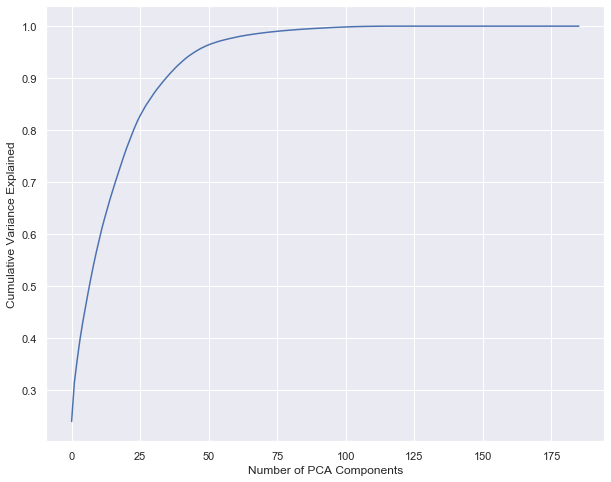

In [100]:
# Generate the screeplot i.e plot the cumulative variance against PCA components
# We observe that around 30 features are enough to explain 90% variance in the training dataset
fig = plt.figure(figsize = (10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [101]:
# Unsupervised PCA with desired accuracy of 90% confidence metric
pca = PCA(0.90)
X_train_pca = pca.fit_transform(X_train)
print('X_train_pca shape:',X_train_pca.shape)

X_train_pca shape: (36206, 36)


In [102]:
# Check the correlation between features by creating correlation matrix for principal components
# We observe that max correlation matrix is not very close zero, we should minimize it,
corr_matrix = np.corrcoef(X_train_pca.transpose())
corr_matrix_diag = corr_matrix - np.diagflat(corr_matrix.diagonal())
print("correlation max:",corr_matrix_diag.max())
print("correlation min:",corr_matrix_diag.min())

correlation max: 9.025355259971412e-16
correlation min: -8.528117298577139e-16


In [103]:
# Applying incremental PCA for efficiency purpose with large datasets
pca = IncrementalPCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
print('X_train_pca shape:',X_train_pca.shape)

print(pca.components_)
X_test_pca = pca.transform(X_test)
print('X_test_pca shape:', X_test_pca.shape)
corr_incr_pca = np.corrcoef(X_train_pca.transpose())

X_train_pca shape: (36206, 30)
[[ 1.65766034e-17  1.55431223e-15  2.22044605e-16 ... -7.76222461e-03
  -2.03926363e-02 -5.71581078e-02]
 [-1.66904742e-17 -4.71844785e-16 -7.21644966e-16 ...  2.78844563e-03
   8.98596515e-03  7.62562384e-03]
 [ 6.54389884e-18  1.38777878e-16  1.14838694e-15 ...  4.93019640e-04
   8.27048534e-03 -8.09834957e-03]
 ...
 [-7.00157023e-17  1.99840144e-15  4.02455846e-16 ... -8.04309771e-03
  -1.35795784e-02 -1.73958427e-01]
 [ 1.16630821e-17  5.11743425e-16  2.09901541e-16 ... -3.00841604e-04
   4.70605563e-03  1.00453081e-01]
 [ 1.36432537e-16 -2.58126853e-15 -8.60422844e-16 ... -7.78500793e-03
  -1.79365366e-02 -1.40741219e-01]]
X_test_pca shape: (8442, 30)


In [104]:
# Recheck the correlation between features by creating correlation matrix for principal components
# We observe that correlation between features is close to zero, so means we have independent features
# This will help us to build stable model ahead
corr_matrix = np.corrcoef(X_train_pca.transpose())
corr_matrix_diag = corr_matrix - np.diagflat(corr_matrix.diagonal())
print("correlation max:",corr_matrix_diag.max())
print("correlation min:",corr_matrix_diag.min())

correlation max: 0.07400549646509437
correlation min: -0.04762995719284121


### The Test-Train splits to be considred going forward
- Balanced PCA Test-Train Split: X_train_pca, X_test_pca, y_train,  y_test
- Balanced non-PCA Test-Train Split:X_train, X_test, y_train,  y_test

In [105]:
# Checking the Churn Rate
churn = (sum(telecom_data['churn_status'])/len(telecom_data['churn_status'].index))*100
print("We have",churn,"churn rate")

We have 7.935887412040657 churn rate


### Sample Model to test ROC: Logistic Regression

In [106]:
learner_pca = LogisticRegression(class_weight='balanced')

In [107]:
model_performance(learner_pca, X_train_pca, y_train, X_test_pca, y_test)


Model Report
--------------
On training data:
ROC_AUC predict score:		0.8330
Recall/Sensitivity score:	0.8490
ROC/AUC predict_proba score:	0.9058

On test data:
ROC_AUC predict score:		0.8252
Recall/Sensitivity score:	0.8359
ROC/AUC predict_proba score:	0.8947



#### The ROC shows a good fit for this sample model. However we will try different other quality models and choose the metrics which will help us identify the maximum number of churn.

#### Varieties of model built
- Model 1: Without PCA: Random Forest + Feature importance
- Model 2: Without PCA: Logistic Regression + Manual Selection(top 50 using Model 1) + RFE
- Model 3: With PCA Logistic regression
- Model 4: With PCA Random Forest with default hyperparameters
- Model 5: With PCA Random Forest with hyperparameter tuning
- Model 6: With PCA Gradient Boosting with default hyperparameter
- Model 7: With PCA Gradient Boosting with hyperparameter tuning

### Model 1: Without PCA: Random Forest + Feature importance

#### The splits for this model: X_train, X_test, y_train,  y_test

In [108]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': range(1, 200, 1),
    'min_samples_leaf': range(1, 1000,1),
    'min_samples_split': range(1, 1000, 1),
    'n_estimators': range(1, 300, 1), 
    'max_features': range(1, 300, 1),
}
# Create a based model
rf_model = RandomForestClassifier()
rf_train = rf_model.fit(X_train, y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print("These are the top 20 features:")
feature_importances[:20]

These are the top 20 features:


,importance
loc_ic_mou_8,0.058261
loc_og_mou_8,0.053387
day_of_last_rech_8,0.040818
last_day_rch_amt_8,0.036793
roam_ic_mou_8,0.032338
max_rech_amt_8,0.027113
total_rech_data_8,0.026962
roam_og_mou_8,0.026525
derived_flag_loc_ic_t2m_mou,0.026280
max_rech_data_8,0.022889


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7802
           1       0.64      0.69      0.66       640

    accuracy                           0.95      8442
   macro avg       0.81      0.83      0.82      8442
weighted avg       0.95      0.95      0.95      8442

Accuracy:	 0.9466950959488273
ROC:		 0.9431308678864394


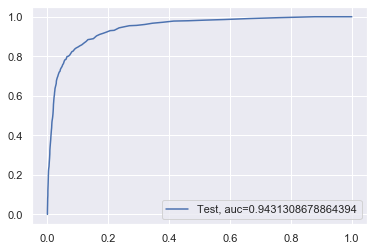

In [109]:
y_test_pred = rf_train.predict(X_test)
y_test_prob = rf_train.predict_proba(X_test)[:,1]

print(metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)
print("ROC:\t\t", metrics.auc(fpr, tpr))
plt.plot(fpr,tpr,label="Test, auc="+str(metrics.auc(fpr, tpr)))
plt.legend(loc=4)
plt.show()

In [110]:
Model_1_recall=metrics.recall_score(y_test, y_test_pred)

In [111]:
metrics.recall_score(y_test, y_test_pred)

0.6921875

### Model 2: Without PCA: Logistic Regression + Manual Selection(top 50 using Model 1) + RFE

#### The splits for this model: X_train, X_test, y_train,  y_test

In [112]:
#Select Top 50 from the Model 1
top_50_cols=feature_importances[:50].reset_index().iloc[:,0]

In [113]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           churn_status   No. Observations:                36206
Model:                            GLM   Df Residuals:                    36080
Model Family:                Binomial   Df Model:                          125
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12086.
Date:                Mon, 18 May 2020   Deviance:                       24172.
Time:                        11:42:59   Pearson chi2:                 5.95e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -1876.4490    747.573     -2.510      0.012   -3341.665    -411.233
loc_og_t2o_mou                  9.832e-07   3.53e-07      2.784      0.005    2.91e-07    1.68e-06
std_og_t2o_mou                  4.482e-07   2.65e-07      1.689      0.091   -7.18e-08    9.68e-07
loc_ic_t2o_mou                  1.786e-07    8.4e-08      2.126      0.034    1.39e-08    3.43e-07
roam_ic_mou_6                   -415.1526    165.178     -2.513      0.012    -738.895     -91.410
roam_ic_mou_7                      4.9279      1.505      3.274      0.001       1.978       7.878
roam_ic_mou_8                    398.4267    158.855      2.508      0.012      87.078     709.776
roam_og_mou_6                   -435.2851    176.567     -2.465      0.014    -781.351     -89.219
roam_og_mou_7                      0.2238      3.136      0.071      0.943      -5.923       6.371
roam_og_mou_8                    405.7819    160.360      2.530      0.011      91.482     720.081
loc_og_t2c_mou_6                -301.9523    119.850     -2.519      0.012    -536.855     -67.050
loc_og_t2c_mou_7                 -51.0906     20.115     -2.540      0.011     -90.515     -11.666
loc_og_t2c_mou_8                 395.9563    157.475      2.514      0.012      87.311     704.601
loc_og_mou_6                   -4.606e+04   8773.651     -5.250      0.000   -6.33e+04   -2.89e+04
loc_og_mou_7                    -3.78e+04   7189.137     -5.257      0.000   -5.19e+04   -2.37e+04
loc_og_mou_8                   -1.639e+04   3108.803     -5.272      0.000   -2.25e+04   -1.03e+04
std_og_t2c_mou_6                8.108e-07   2.86e-07      2.839      0.005    2.51e-07    1.37e-06
std_og_t2c_mou_7                1.153e-06   1.23e-07      9.392      0.000    9.12e-07    1.39e-06
std_og_t2c_mou_8                1.278e-06   1.35e-07      9.486      0.000    1.01e-06    1.54e-06
std_og_mou_6                    2.201e+04   1.82e+04      1.212      0.226   -1.36e+04    5.76e+04
std_og_mou_7                    1.912e+04   1.54e+04      1.243      0.214    -1.1e+04    4.93e+04
std_og_mou_8                    7272.4056   5328.221      1.365      0.172   -3170.715    1.77e+04
og_others_6                     -745.4538    298.779     -2.495      0.013   -1331.049    -159.858
og_others_7                     -319.7807    129.011     -2.479      0.013    -572.639     -66.923
og_others_8                      391.6573    167.801      2.334      0.020      62.774     720.541
loc_ic_mou_6                   -5.587e+04   8364.835     -6.679      0.000   -7.23e+04   -3.95e+04
loc_ic_mou_7                   -4.626e+04   6919.586     -6.686      0.000   -5.98e+04   -3.27e+04
loc_ic_mou_8                    -2.16e+04   3227.547     -6.692      0.000   -2.79e+04   -1.53e+04
std_ic_t2o_mou

# Feature Selection Using RFE

In [114]:
#Logistic Regression with RFE

logreg = LogisticRegression()

In [115]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 20)            
rfe = rfe.fit(X_train[top_50_cols], y_train)

In [116]:
X_train_rfe=pd.DataFrame(X_train[top_50_cols])
y_train_rfe=list(y_train)

In [117]:
print(list(zip(X_train_rfe.columns, rfe.support_, rfe.ranking_)))

[('loc_ic_mou_8', True, 1), ('loc_og_mou_8', True, 1), ('day_of_last_rech_8', True, 1), ('last_day_rch_amt_8', True, 1), ('roam_ic_mou_8', False, 24), ('max_rech_amt_8', True, 1), ('total_rech_data_8', True, 1), ('roam_og_mou_8', True, 1), ('derived_flag_loc_ic_t2m_mou', False, 4), ('max_rech_data_8', True, 1), ('max_rech_amt8minus7', True, 1), ('roam_og_mou8minus7', False, 5), ('av_rech_amt_data_8', False, 18), ('roam_ic_mou8minus7', False, 25), ('derived_flag_total_ic_mou', False, 26), ('total_rech_num_8', True, 1), ('date_of_last_rech_8minus7', False, 10), ('std_ic_mou8minus7', True, 1), ('std_og_mou8minus7', True, 1), ('dayofweek_of_last_rech_8', False, 6), ('loc_ic_mou8minus7', True, 1), ('derived_flag_loc_ic_t2t_mou', False, 12), ('std_ic_mou_8', True, 1), ('derived_flag_total_og_mou', False, 27), ('loc_og_mou8minus7', True, 1), ('count_rech_2g_8', True, 1), ('derived_flag_onnet_mou', False, 21), ('roam_og_mou_7', False, 2), ('derived_flag_loc_og_t2t_mou', False, 30), ('derived_f

In [118]:
col = X_train_rfe.columns[rfe.support_]

In [119]:
X_train_rfe.columns[~rfe.support_]

Index(['roam_ic_mou_8', 'derived_flag_loc_ic_t2m_mou', 'roam_og_mou8minus7',
       'av_rech_amt_data_8', 'roam_ic_mou8minus7', 'derived_flag_total_ic_mou',
       'date_of_last_rech_8minus7', 'dayofweek_of_last_rech_8',
       'derived_flag_loc_ic_t2t_mou', 'derived_flag_total_og_mou',
       'derived_flag_onnet_mou', 'roam_og_mou_7',
       'derived_flag_loc_og_t2t_mou', 'derived_flag_loc_ic_t2f_mou',
       'derived_flag_loc_og_t2m_mou', 'derived_flag_vol_2g_mb',
       'derived_flag_total_rech_amt', 'derived_flag_std_ic_t2t_mou',
       'total_rech_num_7', 'derived_flag_offnet_mou',
       'derived_avg_std_og_t2t_mou_6_7', 'derived_flag_std_og_t2m_mou',
       'loc_ic_mou_6', 'derived_avg_total_ic_mou_6_7', 'roam_ic_mou7minus6',
       'std_og_mou_8', 'derived_flag_arpu', 'derived_avg_std_ic_t2t_mou_6_7',
       'derived_avg_loc_ic_t2m_mou_6_7', 'last_day_rch_amt_6'],
      dtype='object')

In [120]:
X_train_sm = sm.add_constant(X_train_rfe[col])
logm2 = sm.GLM(y_train_rfe,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                36206
Model:                            GLM   Df Residuals:                    36186
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14103.
Date:                Mon, 18 May 2020   Deviance:                       28207.
Time:                        11:43:07   Pearson chi2:                 5.55e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.9538      0.420     33.186      0.000      13.130      14.778
loc_ic_mou_8            -16.6719      0.522    -31.956      0.000     -17.694     -15.649
loc_og_mou_8             -4.9348      0.500     -9.876      0.000      -5.914      -3.955
day_of_last_rech_8       -2.1432      0.082    -26.043      0.000      -2.304      -1.982
last_day_rch_amt_8       -8.4550      0.333    -25.408      0.000      -9.107      -7.803
max_rech_amt_8            2.7708      0.340      8.138      0.000       2.103       3.438
total_rech_data_8        -2.4836      0.774     -3.209      0.001      -4.001      -0.966
roam_og_mou_8             2.3444      0.240      9.766      0.000       1.874       2.815
max_rech_data_8          -5.2029      0.237    -21.985      0.000      -5.667      -4.739
max_rech_amt8minus7      -1.9911      0.453     -4.391      0.000      -2.880      -1.102
total_rech_num_8         -3.6651      0.252    -14.542      0.000      -4.159      -3.171
std_ic_mou8minus7        -2.4961      0.626     -3.986      0.000      -3.724      -1.269
std_og_mou8minus7        -4.0027      0.351    -11.409      0.000      -4.690      -3.315
loc_ic_mou8minus7        -7.3071      0.465    -15.717      0.000      -8.218      -6.396
std_ic_mou_8             -7.5627      0.566    -13.366      0.000      -8.672      -6.454
loc_og_mou8minus7        -3.0212      0.562     -5.376      0.000      -4.123      -1.920
count_rech_2g_8          -5.6885      0.798     -7.124      0.000      -7.254      -4.123
total_rech_num8minus7    -2.5391      0.381     -6.661      0.000      -3.286      -1.792
roam_ic_mou_7             2.5401      0.283      8.960      0.000       1.984       3.096
last_day_rch_amt_7       -1.8124      0.271     -6.696      0.000      -2.343      -1.282
loc_ic_mou_7             -1.6333      0.291     -5.603      0.000      -2.205      -1.062
=========================================================================================
"""

In [121]:
# Getting the predicted values on the train set
y_train_pred_rfe = res.predict(X_train_sm)
y_train_pred_rfe[:10]

0    0.263497
1    0.275424
2    0.345442
3    0.003037
4    0.159996
5    0.497473
6    0.916131
7    0.114404
8    0.611951
9    0.026289
dtype: float64

In [122]:
y_train_pred_rfe = y_train_pred_rfe.values.reshape(-1)
y_train_pred_rfe[:10]

array([0.26349664, 0.27542404, 0.34544226, 0.00303677, 0.15999596,
       0.49747341, 0.91613116, 0.11440405, 0.6119508 , 0.02628862])

In [123]:
y_train_pred_final = pd.DataFrame({'churn_status':y_train.values, 'Churn_Prob':y_train_pred_rfe})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head() 

,churn_status,Churn_Prob,CustID
0,0,0.263497,0
1,0,0.275424,1
2,0,0.345442,2
3,0,0.003037,3
4,0,0.159996,4


### Precision and recall tradeoff

In [124]:
p, r, thresholds = metrics.precision_recall_curve(y_train_pred_final.churn_status, y_train_pred_final.Churn_Prob)

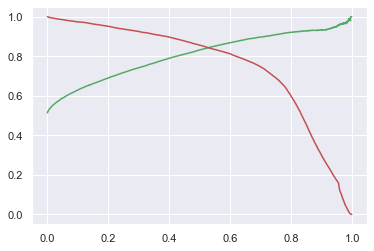

In [125]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [126]:
#Based on the Precision and recall curve the optimal tradeoff is chosen

y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the predicted mixture of 1 & 0s
y_train_pred_final.predicted.value_counts()

1    18635
0    17571
Name: predicted, dtype: int64

In [127]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.churn_status, y_train_pred_final.predicted )
print(confusion)

[[14967  3136]
 [ 2604 15499]]


In [128]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [129]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.churn_status, y_train_pred_final.predicted))

0.8414627409821577


In [130]:
metrics.precision_score(y_train_pred_final.churn_status, y_train_pred_final.predicted)

0.8317145156962704

In [131]:
metrics.recall_score(y_train_pred_final.churn_status, y_train_pred_final.predicted)

0.8561564381594211

In [132]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8561564381594211

In [133]:
# Let us calculate specificity
TN / float(TN+FP)

0.8267690438048942

## Make predictions on Test Set

In [134]:
X_test_rfe=X_test[col]
X_test_rfe

,loc_ic_mou_8,loc_og_mou_8,day_of_last_rech_8,last_day_rch_amt_8,max_rech_amt_8,total_rech_data_8,roam_og_mou_8,max_rech_data_8,max_rech_amt8minus7,total_rech_num_8,std_ic_mou8minus7,std_og_mou8minus7,loc_ic_mou8minus7,std_ic_mou_8,loc_og_mou8minus7,count_rech_2g_8,total_rech_num8minus7,roam_ic_mou_7,last_day_rch_amt_7,loc_ic_mou_7
8694,0.052915,0.114544,0.766667,0.000000,0.147145,0.038462,0.000000,0.161935,0.529204,0.056818,0.501004,0.488743,0.437623,0.001665,0.471946,0.04,0.520325,0.000000,0.166667,0.126461
75152,0.031158,0.018538,1.000000,0.006761,0.010006,0.153846,0.000000,0.017876,0.485237,0.170455,0.508050,0.500234,0.526694,0.002079,0.515950,0.16,0.601626,0.000000,0.006667,0.011381
84755,0.028589,0.018549,1.000000,0.013523,0.038258,0.000000,0.040879,0.000000,0.540436,0.261364,0.507984,0.479495,0.509996,0.009452,0.501527,0.00,0.487805,0.000000,0.006667,0.026294
53455,0.022129,0.033192,0.833333,0.135227,0.117716,0.038462,0.000000,0.208202,0.545250,0.056818,0.480468,0.494397,0.497114,0.028779,0.498052,0.04,0.504065,0.032316,0.000000,0.033312
36488,0.017325,0.019683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.482670,0.000000,0.511269,0.496585,0.496034,0.006294,0.489588,0.00,0.479675,0.000000,0.085333,0.029629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47394,0.080100,0.101016,0.833333,0.041244,0.116539,0.038462,0.000000,0.208202,0.529204,0.147727,0.506462,0.500234,0.476241,0.000000,0.536265,0.04,0.528455,0.000000,0.013333,0.113258
49564,0.232269,0.256143,0.966667,0.087897,0.076516,0.000000,0.000000,0.000000,0.394416,0.125000,0.545744,0.371756,0.566441,0.086172,0.587595,0.00,0.455285,0.406702,0.086667,0.171272
4422,0.171624,0.315208,0.900000,0.087897,0.118893,0.115385,0.000000,0.212408,0.529204,0.170455,0.506363,0.499901,0.572619,0.000000,0.523816,0.08,0.528455,0.000000,0.066667,0.104035
22896,0.031999,0.024775,1.000000,0.033807,0.045321,0.000000,0.026328,0.000000,0.537869,0.159091,0.487601,0.498996,0.516672,0.056500,0.503556,0.00,0.504065,0.054014,0.033333,0.022719


In [135]:
X_test_sm = sm.add_constant(X_test_rfe)

In [136]:
y_test_pred = res.predict(X_test_sm)

In [137]:
y_test_pred[:10]

8694     0.303770
75152    0.113274
84755    0.377963
53455    0.158751
36488    0.941067
83093    0.571082
19617    0.001450
99468    0.111912
73080    0.407972
11674    0.427401
dtype: float64

In [138]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [139]:
# Let's see the head
y_pred_1.head()

,0
8694,0.303770
75152,0.113274
84755,0.377963
53455,0.158751
36488,0.941067


In [140]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [141]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [142]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [143]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [144]:
y_pred_final.head()

,churn_status,CustID,0
0,0,8694,0.303770
1,0,75152,0.113274
2,0,84755,0.377963
3,0,53455,0.158751
4,1,36488,0.941067


In [145]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [146]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['CustID','churn_status','Churn_Prob'], axis=1)

In [147]:
# Let's see the head of y_pred_final
y_pred_final.head()

,CustID,churn_status,Churn_Prob
0,8694,0,0.303770
1,75152,0,0.113274
2,84755,0,0.377963
3,53455,0,0.158751
4,36488,1,0.941067


In [148]:
#Use the same optimal tradeoff chosen based on the Precision and recall curve from the train-set

y_pred_final['predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the predicted mixture of 1 & 0s
y_pred_final.predicted.value_counts()

0    6576
1    1866
Name: predicted, dtype: int64

In [149]:
# Confusion matrix 
confusionT = metrics.confusion_matrix(y_pred_final.churn_status, y_pred_final.predicted )
print(confusion)

[[14967  3136]
 [ 2604 15499]]


In [150]:
TP = confusionT[1,1] # true positive 
TN = confusionT[0,0] # true negatives
FP = confusionT[0,1] # false positives
FN = confusionT[1,0] # false negatives

In [151]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_pred_final.churn_status, y_pred_final.predicted))

0.8325041459369817


In [152]:
metrics.precision_score(y_pred_final.churn_status, y_pred_final.predicted)

0.29260450160771706

In [153]:
metrics.recall_score(y_pred_final.churn_status, y_pred_final.predicted)

0.853125

In [154]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.853125

In [155]:
# Let us calculate specificity
TN / float(TN+FP)

0.8308126121507305

In [156]:
Model_2_recall=metrics.recall_score(y_pred_final.churn_status, y_pred_final.predicted)

In [157]:
metrics.recall_score(y_pred_final.churn_status, y_pred_final.predicted)

0.853125

#### Here you see that accuracy is similary to training set. Due to the precision vs recall tradeoff our precision is affected but the recall which is more important to our business case remains similar to train set. Our task is to predict the churn indicators so in that case its doing a decent job in recall



### Model 3: With PCA Logistic regression
#### The splits for this model: X_train_pca, X_test_pca, y_train,  y_test

In [158]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train_pca)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           churn_status   No. Observations:                36206
Model:                            GLM   Df Residuals:                    36175
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14200.
Date:                Mon, 18 May 2020   Deviance:                       28400.
Time:                        11:43:07   Pearson chi2:                 4.94e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2018      0.016    -12.441      0.000      -0.234      -0.170
x1             1.7537      0.018     96.495      0.000       1.718       1.789
x2            -0.9627      0.026    -37.332      0.000      -1.013      -0.912
x3            -0.6618      0.031    -21.554      0.000      -0.722      -0.602
x4             1.2512      0.035     36.219      0.000       1.183       1.319
x5             0.0253      0.035      0.727      0.467      -0.043       0.094
x6            -0.3329      0.037     -8.923      0.000      -0.406      -0.260
x7             0.6721      0.037     18.170      0.000       0.600       0.745
x8             0.0040      0.039      0.100      0.920      -0.073       0.081
x9            -0.1304      0.040     -3.238      0.001      -0.209      -0.051
x10           -0.1420      0.042     -3.408      0.001      -0.224      -0.060
x11           -0.5316      0.042    -12.724      0.000      -0.613      -0.450
x12           -0.6907      0.044    -15.633      0.000      -0.777      -0.604
x13            0.7759      0.045     17.086      0.000       0.687       0.865
x14           -1.1469      0.049    -23.181      0.000      -1.244      -1.050
x15           -1.2771      0.051    -25.018      0.000      -1.377      -1.177
x16            0.6242      0.050     12.423      0.000       0.526       0.723
x17           -0.5261      0.052    -10.132      0.000      -0.628      -0.424
x18           -0.9879      0.055    -18.046      0.000      -1.095      -0.881
x19           -0.1235      0.052     -2.391      0.017      -0.225      -0.022
x20           -0.3404      0.053     -6.432      0.000      -0.444      -0.237
x21            0.6245      0.061     10.164      0.000       0.504       0.745
x22            0.0092      0.061      0.151      0.880      -0.110       0.128
x23           -0.3572      0.060     -5.928      0.000      -0.475      -0.239
x24           -0.1467      0.058     -2.528      0.011      -0.260      -0.033
x25            0.2775      0.061      4.574      0.000       0.159       0.396
x26           -0.1004      0.064     -1.558      0.119      -0.227       0.026
x27            0.1065      0.074      1.447      0.148      -0.038       0.251
x28            0.8878      0.076     11.646      0.000       0.738       1.037
x29            0.1627      0.083      1.960      0.050    2.23e-05       0.325
x30           -0.4668      0.075     -6.197      0.000      -0.614      -0.319
==============================================================================
"""

In [159]:
logreg = LogisticRegression()
lr_pca = logreg.fit(X_train_pca, y_train)

In [160]:
X_train_sm = sm.add_constant(X_train_pca)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           churn_status   No. Observations:                36206
Model:                            GLM   Df Residuals:                    36175
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14200.
Date:                Mon, 18 May 2020   Deviance:                       28400.
Time:                        11:43:08   Pearson chi2:                 4.94e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2018      0.016    -12.441      0.000      -0.234      -0.170
x1             1.7537      0.018     96.495      0.000       1.718       1.789
x2            -0.9627      0.026    -37.332      0.000      -1.013      -0.912
x3            -0.6618      0.031    -21.554      0.000      -0.722      -0.602
x4             1.2512      0.035     36.219      0.000       1.183       1.319
x5             0.0253      0.035      0.727      0.467      -0.043       0.094
x6            -0.3329      0.037     -8.923      0.000      -0.406      -0.260
x7             0.6721      0.037     18.170      0.000       0.600       0.745
x8             0.0040      0.039      0.100      0.920      -0.073       0.081
x9            -0.1304      0.040     -3.238      0.001      -0.209      -0.051
x10           -0.1420      0.042     -3.408      0.001      -0.224      -0.060
x11           -0.5316      0.042    -12.724      0.000      -0.613      -0.450
x12           -0.6907      0.044    -15.633      0.000      -0.777      -0.604
x13            0.7759      0.045     17.086      0.000       0.687       0.865
x14           -1.1469      0.049    -23.181      0.000      -1.244      -1.050
x15           -1.2771      0.051    -25.018      0.000      -1.377      -1.177
x16            0.6242      0.050     12.423      0.000       0.526       0.723
x17           -0.5261      0.052    -10.132      0.000      -0.628      -0.424
x18           -0.9879      0.055    -18.046      0.000      -1.095      -0.881
x19           -0.1235      0.052     -2.391      0.017      -0.225      -0.022
x20           -0.3404      0.053     -6.432      0.000      -0.444      -0.237
x21            0.6245      0.061     10.164      0.000       0.504       0.745
x22            0.0092      0.061      0.151      0.880      -0.110       0.128
x23           -0.3572      0.060     -5.928      0.000      -0.475      -0.239
x24           -0.1467      0.058     -2.528      0.011      -0.260      -0.033
x25            0.2775      0.061      4.574      0.000       0.159       0.396
x26           -0.1004      0.064     -1.558      0.119      -0.227       0.026
x27            0.1065      0.074      1.447      0.148      -0.038       0.251
x28            0.8878      0.076     11.646      0.000       0.738       1.037
x29            0.1627      0.083      1.960      0.050    2.23e-05       0.325
x30           -0.4668      0.075     -6.197      0.000      -0.614      -0.319
==============================================================================
"""

In [161]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

array([0.72441841, 0.73655263, 0.48814672, 0.02704405, 0.05873858,
       0.20039701, 0.90854311, 0.01410968, 0.30939213, 0.01237623])

In [162]:
y_train_pred_final = pd.DataFrame({'churn_status':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head() 

,churn_status,Churn_Prob,CustID
0,0,0.724418,0
1,0,0.736553,1
2,0,0.488147,2
3,0,0.027044,3
4,0,0.058739,4


### Precision and recall tradeoff

In [163]:
p, r, thresholds = metrics.precision_recall_curve(y_train_pred_final.churn_status, y_train_pred_final.Churn_Prob)

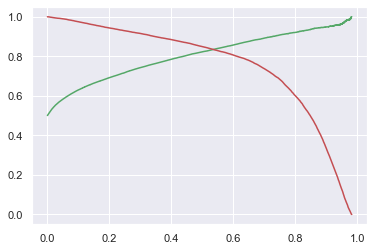

In [164]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [165]:
#Based on the Precision and recall curve the optimal tradeoff is chosen

y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the predicted mixture of 1 & 0s
y_train_pred_final.predicted.value_counts()

1    18672
0    17534
Name: predicted, dtype: int64

In [166]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.churn_status, y_train_pred_final.predicted )
print(confusion)

[[14797  3306]
 [ 2737 15366]]


In [167]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [168]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.churn_status, y_train_pred_final.predicted))

0.8330939623266862


In [169]:
metrics.precision_score(y_train_pred_final.churn_status, y_train_pred_final.predicted)

0.8229434447300771

In [170]:
metrics.recall_score(y_train_pred_final.churn_status, y_train_pred_final.predicted)

0.8488095895707893

In [171]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8488095895707893

In [172]:
# Let us calculate specificity
TN / float(TN+FP)

0.817378335082583

## Make predictions on Test Set

In [173]:
X_test_sm = sm.add_constant(X_test_pca)

In [174]:
y_test_pred = res.predict(X_test_sm)

In [175]:
y_test_pred[:10]

array([0.05470425, 0.03995898, 0.1753883 , 0.05673591, 0.73662181,
       0.08235953, 0.04236595, 0.00422386, 0.16072998, 0.64408074])

In [176]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [177]:
# Let's see the head
y_pred_1.head()

,0
0,0.054704
1,0.039959
2,0.175388
3,0.056736
4,0.736622


In [178]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [179]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [180]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [181]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [182]:
y_pred_final.head()

,churn_status,CustID,0
0,0,8694,0.054704
1,0,75152,0.039959
2,0,84755,0.175388
3,0,53455,0.056736
4,1,36488,0.736622


In [183]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [184]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['CustID','churn_status','Churn_Prob'], axis=1)

In [185]:
# Let's see the head of y_pred_final
y_pred_final.head()

,CustID,churn_status,Churn_Prob
0,8694,0,0.054704
1,75152,0,0.039959
2,84755,0,0.175388
3,53455,0,0.056736
4,36488,1,0.736622


In [186]:
#Use the same optimal tradeoff chosen based on the Precision and recall curve from the train-set

y_pred_final['predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the predicted mixture of 1 & 0s
y_pred_final.predicted.value_counts()

0    6462
1    1980
Name: predicted, dtype: int64

In [187]:
# Confusion matrix 
confusionT = metrics.confusion_matrix(y_pred_final.churn_status, y_pred_final.predicted )
print(confusion)

[[14797  3306]
 [ 2737 15366]]


In [188]:
TP = confusionT[1,1] # true positive 
TN = confusionT[0,0] # true negatives
FP = confusionT[0,1] # false positives
FN = confusionT[1,0] # false negatives

In [189]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_pred_final.churn_status, y_pred_final.predicted))

0.816394219379294


In [190]:
metrics.precision_score(y_pred_final.churn_status, y_pred_final.predicted)

0.2702020202020202

In [191]:
metrics.recall_score(y_pred_final.churn_status, y_pred_final.predicted)

0.8359375

In [192]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8359375

In [193]:
# Let us calculate specificity
TN / float(TN+FP)

0.8147910792104589

In [194]:
Model_3_recall = metrics.recall_score(y_pred_final.churn_status, y_pred_final.predicted)

In [195]:
metrics.recall_score(y_pred_final.churn_status, y_pred_final.predicted)

0.8359375

### Model 4: With PCA Random Forest (default hyperparameters)

First let's try a random forest classifier with default hyperparameters

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7802
           1       0.52      0.64      0.58       640

    accuracy                           0.93      8442
   macro avg       0.75      0.80      0.77      8442
weighted avg       0.94      0.93      0.93      8442

Accuracy score:		0.9279791518597489
Roc_auc_score		0.797522269930787
Sensitivity/Recall:	0.64375
Specificity:		0.951294539861574
False Positive Rate:	0.04870546013842605

Positive predictive Rate: 0.5202020202020202
Negative Predictive Rate: 0.9701960784313726
Precision score value:	0.5202020202020202

ROC on test data:	 0.8917403990963857


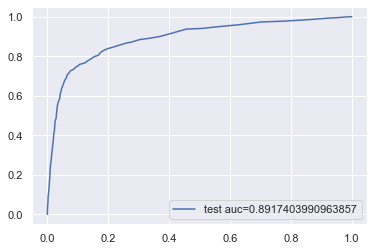

In [196]:
rf_model_0 = RandomForestClassifier()
rf_train_0 = rf_model_0.fit(X_train_pca, y_train)
y_test_pred = rf_train_0.predict(X_test_pca)
y_test_prob = rf_train_0.predict_proba(X_test_pca)[:,1]

compute_metrics(y_test, y_test_pred)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)
print("\nROC on test data:\t", metrics.auc(fpr, tpr))
plt.plot(fpr,tpr,label="test auc="+str(metrics.auc(fpr, tpr)))
plt.legend(loc=4)
plt.show()

In [197]:
Model_4_recall = metrics.recall_score(y_test, y_test_pred)

In [198]:
print('recall score:', metrics.recall_score(y_test, y_test_pred))

recall score: 0.64375


We observe that the default random forest classifier has very high test auc score but the sensitivity is very low

### Model 5: With PCA Random Forest (with hyperparameter tuning)

Let's try applying Random Forest Classifier on our principal components obtained with Hyperparameter tuning.

#### Tuning max_depth
The maximum depth of the tree

In [199]:
# Second model is Random Forest
# First let's tune the max_depth hyperparameter
parameters = {'max_depth': range(10, 30, 5)}
rf_model_1 = RandomForestClassifier()
rf_grid_1 = GridSearchCV(rf_model_1, parameters, return_train_score=True, cv=5, scoring="recall")
rf_grid_1.fit(X_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

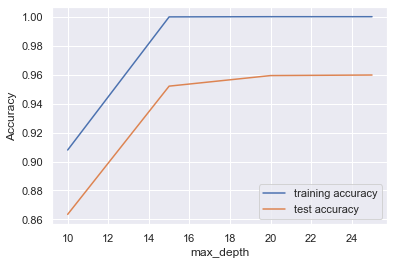

In [200]:
# Let's plot cross validation accuracies with max_depth to find the most optimal max_depth
# Test recall-score becomes almost stable and constant after max_depth of 20
scores = rf_grid_1.cv_results_
plt.figure()
plt.plot(scores["param_max_depth"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting max_depth as 20

#### Tuning n_estimators
The number of trees in the forest.

In [201]:
# Tuning n_estimators now
parameters = {'n_estimators': range(50, 150, 25)}
rf_model_2 = RandomForestClassifier(max_depth=20, random_state=10)
rf_grid_2 = GridSearchCV(rf_model_2, parameters, return_train_score=True, cv=3, scoring="recall")
rf_grid_2.fit(X_train_pca, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=10,
                                    

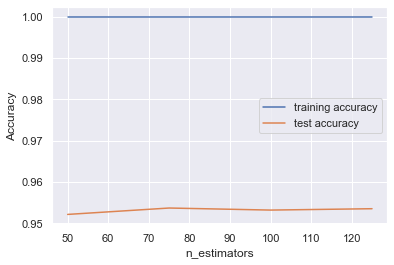

In [202]:
# Let's plot cross validation accuracies with n_estimators to find the most optimal n_estimators
# Based on recall score selecting optimal n_estimators as 80
scores = rf_grid_2.cv_results_
plt.figure()
plt.plot(scores["param_n_estimators"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting n_estimators as 80

#### Tuning max_features
The number of features to consider when looking for the best split

In [203]:
# Next let's tune the max_features hyperparameter
parameters = {'max_features': [4, 8, 14, 20, 24]}
rf_model_3 = RandomForestClassifier(max_depth=20, n_estimators=80, random_state=10)
rf_grid_3 = GridSearchCV(rf_model_3, parameters, return_train_score=True, cv=5, scoring="recall")
rf_grid_3.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=80, n_jobs=None,
                                              oob_score=False, random_state=10,
                                     

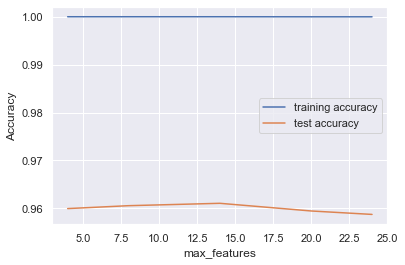

In [204]:
# Let's plot cross validation accuracies with max_features to find the most optimal max_features
# Test recall-score becomes almost stable and constant after max_features of 8
scores = rf_grid_3.cv_results_
plt.figure()
plt.plot(scores["param_max_features"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting max_feature of 8

#### Tuning min_sample_leaf
The minimum number of samples required to be at a leaf node

In [205]:
# Next let's tune the min_sample_leaf hyperparameter
parameters = {'min_samples_leaf': range(100, 400, 50)}
rf_model_4 = RandomForestClassifier(max_depth=20, n_estimators=80, max_features=8, random_state=10)
rf_grid_4 = GridSearchCV(rf_model_4, parameters, return_train_score=True, cv=3, scoring="recall")
rf_grid_4.fit(X_train_pca, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=20,
                                              max_features=8,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=80, n_jobs=None,
                                              oob_score=False, random_state=10,
                                          

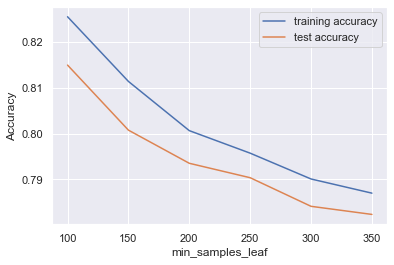

In [206]:
# Let's plot cross validation accurracies with max_depth to find the most optimal min_samples_leaf
# Test recall-score becomes almost stable and constant after min_samples_leaf of 100
scores = rf_grid_4.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_leaf"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting min_samples_leaf of 100

#### Tuning min_sample_split
The minimum number of samples required to split an internal node

In [207]:
# Next let's tune the min_sample_split hyperparameter
parameters = {'min_samples_split': range(50, 300, 50)}
rf_model_5 = RandomForestClassifier(max_depth=20, n_estimators=80, max_features=8,
                                    min_samples_leaf=100, random_state=10)
rf_grid_5 = GridSearchCV(rf_model_5, parameters, return_train_score=True, cv=3, scoring="recall")
rf_grid_5.fit(X_train_pca, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=20,
                                              max_features=8,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=100,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=80, n_jobs=None,
                                              oob_score=False, random_state=10,
                                        

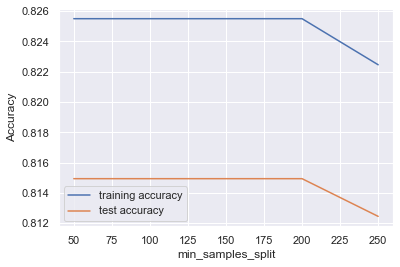

In [208]:
# Let's plot cross validation accurracies with min_sample_split to find the most optimal min_sample_split
# Test recall-score becomes almost stable and constant after min_sample_split of 20
scores = rf_grid_5.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_split"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting min_samples_split of 200

#### Running a tunned Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7802
           1       0.39      0.76      0.51       640

    accuracy                           0.89      8442
   macro avg       0.68      0.83      0.73      8442
weighted avg       0.93      0.89      0.91      8442

Accuracy score:		0.8905472636815921
Roc_auc_score		0.831058342412202
Sensitivity/Recall:	0.7609375
Specificity:		0.901179184824404
False Positive Rate:	0.098820815175596

Positive predictive Rate: 0.3871224165341812
Negative Predictive Rate: 0.9787026726057907
Precision score value:	0.3871224165341812

ROC on test data:	 0.9004698314534734


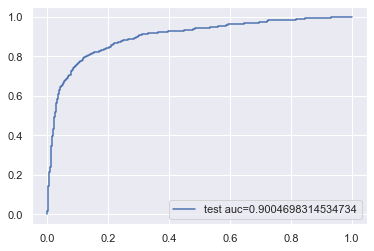

In [209]:
rf_model = RandomForestClassifier(max_depth=20,
                                  n_estimators=80,
                                  max_features=8,
                                  min_samples_leaf=100,
                                  min_samples_split=200,
                                  random_state=10)
rf_train = rf_model.fit(X_train_pca, y_train)
y_test_pred = rf_train.predict(X_test_pca)
y_test_prob = rf_train.predict_proba(X_test_pca)[:,1]

compute_metrics(y_test, y_test_pred)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)
print("\nROC on test data:\t", metrics.auc(fpr, tpr))
plt.plot(fpr,tpr,label="test auc="+str(metrics.auc(fpr, tpr)))
plt.legend(loc=4)
plt.show()

In [210]:
print('recall score:', metrics.recall_score(y_test, y_test_pred))

recall score: 0.7609375


After hyperparameter tuning for the random forest. The recall score on test data is decent. Let's try and check if we can achieve a better recall score by tuning the cut-off for the model and picking the optimal cut-off rate to predict customer churn.

In [211]:
# Creating new column 'churn_final_predicted' with 1 if churn_probability > 0.5 else 0
prob_cut_off = 0.5
y_train_prob = rf_model.predict_proba(X_train_pca)[:,1]
y_train_prob_df = pd.DataFrame({'churn_status':y_train, 'churn_probability':y_train_prob})
y_train_prob_df['churn_final_predicted'] = y_train_prob_df.churn_probability.map(lambda x: 1
                                                                                 if x > prob_cut_off else 0)
compute_metrics(y_train_prob_df.churn_status, y_train_prob_df.churn_final_predicted)
y_train_prob_df.head()

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     18103
           1       0.90      0.84      0.87     18103

    accuracy                           0.87     36206
   macro avg       0.87      0.87      0.87     36206
weighted avg       0.87      0.87      0.87     36206

Accuracy score:		0.8712368115781914
Roc_auc_score		0.8712368115781916
Sensitivity/Recall:	0.8372093023255814
Specificity:		0.9052643208308015
False Positive Rate:	0.09473567916919848

Positive predictive Rate: 0.8983462746725149
Negative Predictive Rate: 0.8475821049909491
Precision score value:	0.8983462746725149


,churn_status,churn_probability,churn_final_predicted
0,0,0.545971,1
1,0,0.344581,0
2,0,0.222051,0
3,0,0.074786,0
4,0,0.050175,0


     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     0.000000     1.000000
0.1          0.1  0.668812     0.337845     0.999779
0.2          0.2  0.819008     0.649727     0.988289
0.3          0.3  0.874192     0.792962     0.955422
0.4          0.4  0.881097     0.860078     0.902116
0.5          0.5  0.871237     0.905264     0.837209
0.6          0.6  0.856930     0.935259     0.778600
0.7          0.7  0.831437     0.957355     0.705518
0.8          0.8  0.799122     0.969287     0.628957
0.9          0.9  0.753218     0.985417     0.521019


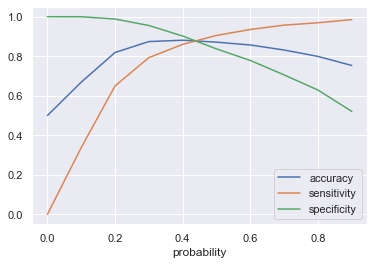

In [212]:
# From the plot below cutoff as 0.43 seems to be an optimal one
# At this optimal point sensitivity is also good enough
find_optimal_cutoff(y_train_prob_df)

In [213]:
# Creating new column 'churn_final_predicted' with 1 if churn_probability > 0.43 else 0
prob_cut_off = 0.43
y_train_prob = rf_model.predict_proba(X_train_pca)[:,1]
y_train_prob_df = pd.DataFrame({'churn_status':y_train, 'churn_probability':y_train_prob})
y_train_prob_df['churn_final_predicted'] = y_train_prob_df.churn_probability.map(lambda x: 1
                                                                                 if x > prob_cut_off else 0)
compute_metrics(y_train_prob_df.churn_status, y_train_prob_df.churn_final_predicted)
y_train_prob_df.head()

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     18103
           1       0.88      0.88      0.88     18103

    accuracy                           0.88     36206
   macro avg       0.88      0.88      0.88     36206
weighted avg       0.88      0.88      0.88     36206

Accuracy score:		0.8796884494282715
Roc_auc_score		0.8796884494282716
Sensitivity/Recall:	0.8837761696956306
Specificity:		0.8756007291609126
False Positive Rate:	0.12439927083908744

Positive predictive Rate: 0.8766095008492686
Negative Predictive Rate: 0.8828181565023671
Precision score value:	0.8766095008492686


,churn_status,churn_probability,churn_final_predicted
0,0,0.545971,1
1,0,0.344581,0
2,0,0.222051,0
3,0,0.074786,0
4,0,0.050175,0


In [214]:
# Making prediction on test data with this optimal cutoff
y_test_prob = rf_model.predict_proba(X_test_pca)[:,1]
y_test_prob_df = pd.DataFrame({'churn_status':y_test, 'churn_probability':y_test_prob})
y_test_prob_df['churn_final_predicted'] = y_test_prob_df.churn_probability.map(lambda x: 1
                                                                               if x > prob_cut_off else 0)
compute_metrics(y_test_prob_df.churn_status, y_test_prob_df.churn_final_predicted)
y_test_prob_df.head()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7802
           1       0.33      0.80      0.47       640

    accuracy                           0.86      8442
   macro avg       0.66      0.84      0.70      8442
weighted avg       0.93      0.86      0.89      8442

Accuracy score:		0.8636579009713338
Roc_auc_score		0.8358742149448859
Sensitivity/Recall:	0.803125
Specificity:		0.8686234298897718
False Positive Rate:	0.13137657011022816

Positive predictive Rate: 0.33398310591293046
Negative Predictive Rate: 0.9817470664928292
Precision score value:	0.33398310591293046


,churn_status,churn_probability,churn_final_predicted
8694,0,0.166710,0
75152,0,0.052423,0
84755,0,0.150595,0
53455,0,0.040886,0
36488,1,0.547179,1


In [215]:
Model_5_recall = metrics.recall_score(y_test_prob_df.churn_status, y_test_prob_df.churn_final_predicted)

In [216]:
metrics.recall_score(y_test_prob_df.churn_status, y_test_prob_df.churn_final_predicted)

0.803125

Random Forest after selecting optimal cut-off also is resulting in a model with decent recall score

### Model 6: With PCA Gradient Boosting (with default hyperparameters)

First let's try a gradient boosting classifier with default hyperparameters

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7802
           1       0.37      0.77      0.50       640

    accuracy                           0.88      8442
   macro avg       0.68      0.83      0.72      8442
weighted avg       0.93      0.88      0.90      8442

Accuracy score:		0.8834399431414357
Roc_auc_score		0.8315161577159703
Sensitivity/Recall:	0.7703125
Specificity:		0.8927198154319406
False Positive Rate:	0.10728018456805948

Positive predictive Rate: 0.3706766917293233
Negative Predictive Rate: 0.9793307086614174
Precision score value:	0.3706766917293233

ROC on test data:	 0.9015146356703411


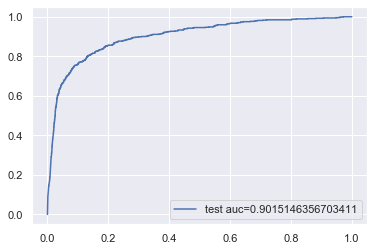

In [217]:
gb_model_0 = ensemble.GradientBoostingClassifier()
gb_train_0 = gb_model_0.fit(X_train_pca, y_train)
y_test_pred = gb_train_0.predict(X_test_pca)
y_test_prob = gb_train_0.predict_proba(X_test_pca)[:,1]

compute_metrics(y_test, y_test_pred)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)
print("\nROC on test data:\t", metrics.auc(fpr, tpr))
plt.plot(fpr,tpr,label="test auc="+str(metrics.auc(fpr, tpr)))
plt.legend(loc=4)
plt.show()

In [218]:
Model_6_recall = metrics.recall_score(y_test, y_test_pred)

In [219]:
print('recall score:', metrics.recall_score(y_test, y_test_pred))

recall score: 0.7703125


We observe that the default gradient boosting classifier has very high test auc score but the sensitivity is slightly low.

Let's try applying Gradient Boosting Classifier on our principal components obtained with Hyperparameter tuning.

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7802
           1       0.36      0.76      0.49       640

    accuracy                           0.88      8442
   macro avg       0.67      0.82      0.71      8442
weighted avg       0.93      0.88      0.90      8442

Accuracy score:		0.8782279080786544
Roc_auc_score		0.8229590569725711
Sensitivity/Recall:	0.7578125
Specificity:		0.8881056139451423
False Positive Rate:	0.11189438605485773

Positive predictive Rate: 0.35714285714285715
Negative Predictive Rate: 0.978119706380576
Precision score value:	0.35714285714285715

ROC on test data:	 0.8969261687708279


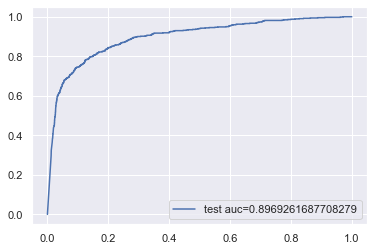

In [220]:
# Fit classifier with random estimates
params = {'n_estimators': 200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 9999}
gb_model = ensemble.GradientBoostingClassifier(**params)
gb_train = gb_model.fit(X_train_pca, y_train)

y_test_pred = gb_train.predict(X_test_pca)
y_test_prob = gb_train.predict_proba(X_test_pca)[:,1]

compute_metrics(y_test, y_test_pred)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)
print("\nROC on test data:\t", metrics.auc(fpr, tpr))
plt.plot(fpr,tpr,label="test auc="+str(metrics.auc(fpr, tpr)))
plt.legend(loc=4)
plt.show()

In [221]:
Model_6_recall = metrics.recall_score(y_test, y_test_pred)

In [222]:
metrics.recall_score(y_test, y_test_pred)

0.7578125

We observe that the random selection of hyperparameters in gradient boosting classifier has very high test auc score but the sensitivity is slightly low is decent, but still low.

### Model 7: With PCA Gradient Boosting (with hyperparameter tuning)

Let's try applying Gradient Boosting Classifier on our principal components obtained with Hyperparameter tuning.

#### Tuning max_depth
The maximum depth of the tree

In [223]:
# First let's tune the max_depth hyperparameter
parameters = {'max_depth': range(5, 16, 2)}
gb_model_1 = ensemble.GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt',
                                                 subsample=0.8, random_state=10)
gb_grid_1 = GridSearchCV(gb_model_1, parameters, return_train_score=True, cv=3, scoring="recall", n_jobs=4, iid=False)
gb_grid_1.fit(X_train_pca,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
       

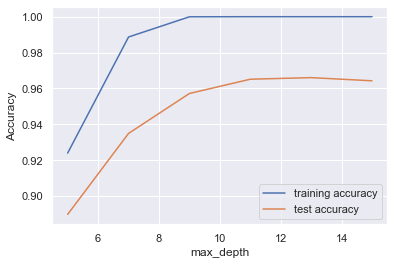

In [224]:
# Let's plot cross validation accuracies with max_depth to find the most optimal max_depth
# Test recall-score becomes almost stable and constant after max_depth of 11
scores = gb_grid_1.cv_results_
plt.figure()
plt.plot(scores["param_max_depth"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting max_depth as 11

#### Tuning n_estimators
The number of trees in the forest.

In [225]:
# Tuning n_estimators now
parameters = {'n_estimators': range(20, 150, 10)}
gb_model_2 = ensemble.GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', max_depth=11,
                                                 subsample=0.8, random_state=10)
gb_grid_2 = GridSearchCV(gb_model_2, parameters, return_train_score=True, cv=3, scoring="recall", n_jobs=4, iid=False)
gb_grid_2.fit(X_train_pca,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=11,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

Best parameters: {'n_estimators': 140} 0.9696732508238091


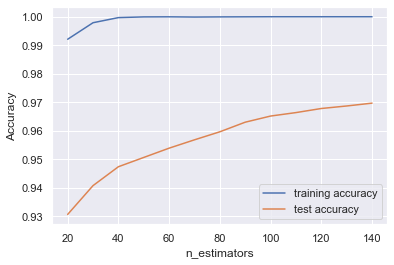

In [226]:
# Let's plot cross validation accuracies with n_estimators to find the most optimal n_estimators
# Based on recall score selecting optimal n_estimators as 140
print('Best parameters:', gb_grid_2.best_params_, gb_grid_2.best_score_)
scores = gb_grid_2.cv_results_
plt.figure()
plt.plot(scores["param_n_estimators"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting n_estimators as 140

#### Tuning max_features
The number of features to consider when looking for the best split

In [227]:
# Next let's tune the max_features hyperparameter
parameters = {'max_features': range(7,20,2)}
gb_model_3 = ensemble.GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', max_depth=11,
                                                 subsample=0.8, random_state=10, n_estimators=140)
gb_grid_3 = GridSearchCV(gb_model_3, parameters, return_train_score=True, cv=3, scoring="recall", n_jobs=4, iid=False)
gb_grid_3.fit(X_train_pca,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=11,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=140,
                                                  n_iter_no_change=None,
      

Best parameters: {'max_features': 11} 0.970502025848737


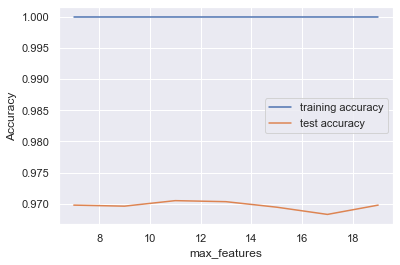

In [228]:
# Let's plot cross validation accuracies with max_features to find the most optimal max_features
# Test recall-score becomes almost stable and constant after max_features of 7
print('Best parameters:', gb_grid_3.best_params_, gb_grid_3.best_score_)
scores = gb_grid_3.cv_results_
plt.figure()
plt.plot(scores["param_max_features"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting max_feature of 7

#### Tuning min_sample_leaf
The minimum number of samples required to be at a leaf node

In [229]:
# Next let's tune the min_sample_leaf hyperparameter
parameters = {'min_samples_leaf': range(30,71,10)}
gb_model_4 = ensemble.GradientBoostingClassifier(learning_rate=0.1, max_features=7, max_depth=11,
                                                 subsample=0.8, random_state=10, n_estimators=140)
gb_grid_4 = GridSearchCV(gb_model_4, parameters, return_train_score=True, cv=3, scoring="recall", n_jobs=4, iid=False)
gb_grid_4.fit(X_train_pca,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=11,
                                                  max_features=7,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=140,
                                                  n_iter_no_change=None,
           

Best parameters: {'min_samples_leaf': 30} 0.9781799664736978


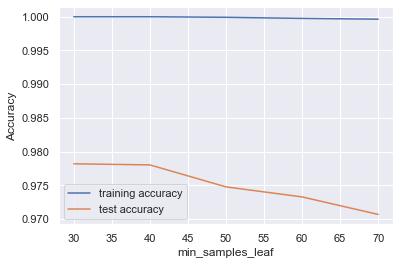

In [230]:
# Let's plot cross validation accurracies with max_depth to find the most optimal min_samples_leaf
# Test recall-score becomes almost stable and constant after min_samples_leaf of 40
print('Best parameters:', gb_grid_4.best_params_, gb_grid_4.best_score_)
scores = gb_grid_4.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_leaf"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting min_samples_leaf of 40

#### Tuning min_sample_split
The minimum number of samples required to split an internal node

In [231]:
# Next let's tune the min_sample_split hyperparameter
parameters = {'min_samples_split': range(200,1001,200)}
gb_model_5 = ensemble.GradientBoostingClassifier(learning_rate=0.1, max_features=7, max_depth=11,
                                                 min_samples_leaf=40, subsample=0.8, random_state=10,
                                                 n_estimators=140)
gb_grid_5 = GridSearchCV(gb_model_5, parameters, return_train_score=True, cv=3, scoring="recall", n_jobs=4, iid=False)
gb_grid_5.fit(X_train_pca,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=11,
                                                  max_features=7,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=40,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=140,
                                                  n_iter_no_change=None,
          

Best parameters: {'min_samples_split': 200} 0.9688995901618712


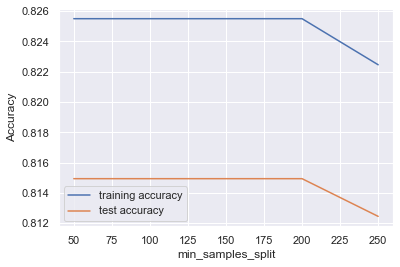

In [232]:
# Let's plot cross validation accurracies with min_sample_split to find the most optimal min_sample_split
# Test recall-score becomes almost stable and constant after min_sample_split of 200
print('Best parameters:', gb_grid_5.best_params_, gb_grid_5.best_score_)
scores = rf_grid_5.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_split"].__array__(), 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"].__array__(), 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Selecting min_samples_split of 200

#### Running a tunned Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      7802
           1       0.47      0.68      0.56       640

    accuracy                           0.92      8442
   macro avg       0.72      0.81      0.76      8442
weighted avg       0.93      0.92      0.92      8442

Accuracy score:		0.9174366263918503
Roc_auc_score		0.809747700910023
Sensitivity/Recall:	0.6828125
Specificity:		0.9366829018200461
False Positive Rate:	0.06331709817995386

Positive predictive Rate: 0.46938775510204084
Negative Predictive Rate: 0.972972972972973
Precision score value:	0.46938775510204084

ROC on test data:	 0.8971299426429121


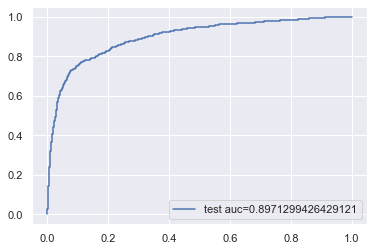

In [233]:
gb_model = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, max_features=7, max_depth=11,
                                  min_samples_split=200, min_samples_leaf=40, subsample=0.8, random_state=10)

gb_train = gb_model.fit(X_train_pca, y_train)
y_test_pred = gb_train.predict(X_test_pca)
y_test_prob = gb_train.predict_proba(X_test_pca)[:,1]

compute_metrics(y_test, y_test_pred)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_prob)
print("\nROC on test data:\t", metrics.auc(fpr, tpr))
plt.plot(fpr,tpr,label="test auc="+str(metrics.auc(fpr, tpr)))
plt.legend(loc=4)
plt.show()

In [234]:
print('recall score:', metrics.recall_score(y_test, y_test_pred))

recall score: 0.6828125


After hyperparameter tuning for the random forest. The recall score on test data is low. Let's try and check if we can achieve a better recall score by tuning the cut-off for the model and picking the optimal cut-off rate to predict customer churn.

In [235]:
# Creating new column 'churn_final_predicted' with 1 if churn_probability > 0.5 else 0
prob_cut_off = 0.5
y_train_prob = gb_model.predict_proba(X_train_pca)[:,1]
y_train_prob_df = pd.DataFrame({'churn_status':y_train, 'churn_probability':y_train_prob})
y_train_prob_df['churn_final_predicted'] = y_train_prob_df.churn_probability.map(lambda x: 1
                                                                                 if x > prob_cut_off else 0)
compute_metrics(y_train_prob_df.churn_status, y_train_prob_df.churn_final_predicted)
y_train_prob_df.head()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     18103
           1       0.97      1.00      0.99     18103

    accuracy                           0.99     36206
   macro avg       0.99      0.99      0.99     36206
weighted avg       0.99      0.99      0.99     36206

Accuracy score:		0.9865215710103298
Roc_auc_score		0.9865215710103297
Sensitivity/Recall:	0.9996133237584931
Specificity:		0.9734298182621665
False Positive Rate:	0.026570181737833508

Positive predictive Rate: 0.9741077676696991
Negative Predictive Rate: 0.9996029269952919
Precision score value:	0.9741077676696991


,churn_status,churn_probability,churn_final_predicted
0,0,0.180164,0
1,0,0.077752,0
2,0,0.019115,0
3,0,0.003981,0
4,0,0.004514,0


     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     0.000000     1.000000
0.1          0.1  0.942882     0.885765     1.000000
0.2          0.2  0.967243     0.934486     1.000000
0.3          0.3  0.976910     0.953820     1.000000
0.4          0.4  0.982572     0.965310     0.999834
0.5          0.5  0.986522     0.973430     0.999613
0.6          0.6  0.988648     0.978788     0.998509
0.7          0.7  0.989615     0.983704     0.995526
0.8          0.8  0.983732     0.990057     0.977407
0.9          0.9  0.930702     0.996078     0.865326


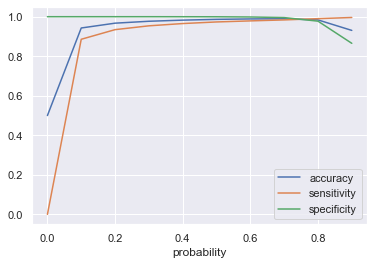

In [236]:
# From the plot below cutoff as 0.43 seems to be an optimal one
# At this optimal point sensitivity is also good enough
find_optimal_cutoff(y_train_prob_df)

In [237]:
# Creating new column 'churn_final_predicted' with 1 if churn_probability > 0.1 else 0
prob_cut_off = 0.1
y_train_prob = gb_model.predict_proba(X_train_pca)[:,1]
y_train_prob_df = pd.DataFrame({'churn_status':y_train, 'churn_probability':y_train_prob})
y_train_prob_df['churn_final_predicted'] = y_train_prob_df.churn_probability.map(lambda x: 1
                                                                                 if x > prob_cut_off else 0)
compute_metrics(y_train_prob_df.churn_status, y_train_prob_df.churn_final_predicted)
y_train_prob_df.head()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     18103
           1       0.90      1.00      0.95     18103

    accuracy                           0.94     36206
   macro avg       0.95      0.94      0.94     36206
weighted avg       0.95      0.94      0.94     36206

Accuracy score:		0.9428823951831188
Roc_auc_score		0.9428823951831189
Sensitivity/Recall:	1.0
Specificity:		0.8857647903662377
False Positive Rate:	0.11423520963376237

Positive predictive Rate: 0.8974765752813445
Negative Predictive Rate: 1.0
Precision score value:	0.8974765752813445


,churn_status,churn_probability,churn_final_predicted
0,0,0.180164,1
1,0,0.077752,0
2,0,0.019115,0
3,0,0.003981,0
4,0,0.004514,0


In [238]:
# Making prediction on test data with this optimal cutoff
prob_cut_off = 0.1
y_test_prob = gb_model.predict_proba(X_test_pca)[:,1]
y_test_prob_df = pd.DataFrame({'churn_status':y_test, 'churn_probability':y_test_prob})
y_test_prob_df['churn_final_predicted'] = y_test_prob_df.churn_probability.map(lambda x: 1
                                                                               if x > prob_cut_off else 0)
compute_metrics(y_test_prob_df.churn_status, y_test_prob_df.churn_final_predicted)
y_test_prob_df.head()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7802
           1       0.27      0.82      0.40       640

    accuracy                           0.82      8442
   macro avg       0.63      0.82      0.65      8442
weighted avg       0.93      0.82      0.86      8442

Accuracy score:		0.8173418621179815
Roc_auc_score		0.8165538483722123
Sensitivity/Recall:	0.815625
Specificity:		0.8174826967444245
False Positive Rate:	0.1825173032555755

Positive predictive Rate: 0.2682425488180884
Negative Predictive Rate: 0.9818349753694581
Precision score value:	0.2682425488180884


,churn_status,churn_probability,churn_final_predicted
8694,0,0.016572,0
75152,0,0.001976,0
84755,0,0.007182,0
53455,0,0.004213,0
36488,1,0.358362,1


In [239]:
Model_7_recall = metrics.recall_score(y_test_prob_df.churn_status, y_test_prob_df.churn_final_predicted)

In [240]:
metrics.recall_score(y_test_prob_df.churn_status, y_test_prob_df.churn_final_predicted)

0.815625

This model is purely overfitting since there is a huge variance between training and test scores. Gradient Boosting after selecting optimal cut-off is resulting in a model with Test Recall with decent score. But advantage with this model is the balance between precision and recall which we don't get without PCA models

## Step 6: Model Selection

### Best Model Selection

Recall is the most important business metric for the telecom churn problem. The company would like to identify most customers at risk of churning, even if there are many customers that are misclassified as churn. The cost to the company of churning is much higher than having a few false positives.

#### Varieties of models built
- Model 1: Without PCA: Random Forest + Feature importance
- Model 2: Without PCA: Logistic Regression + Manual Selection(top 50 using Model 1) + RFE
- Model 3: With PCA Logistic regression
- Model 4: With PCA Random Forest with default hyperparameters
- Model 5: With PCA Random Forest with hyperparameter tuning
- Model 6: With PCA Gradient Boosting with default hyperparameter
- Model 7: With PCA Gradient Boosting with hyperparameter tuning

In [241]:
all_model_recall_score=[Model_1_recall,Model_2_recall,Model_3_recall,
                        Model_4_recall,Model_5_recall,Model_6_recall,Model_7_recall]
model_names=['Model_1 Random Forest without PCA','Model_2 Logistic Regression without PCA',
             'Model_3 Logistic Regression with PCA','Model_4 Random Forest with default',
             'Model_5 Random Forest with hyperparameter tuning',
             'Model_6 Gradient Boosting with default hyperparameters',
             'Model_7 Gradient Boosting with hyperparameter tuning']

In [242]:
recall_scores=(pd.DataFrame(all_model_recall_score,model_names).reset_index())
recall_scores.columns=['Model_Number','Recall_Score']
recall_scores=recall_scores.set_index('Model_Number')
recall_scores=recall_scores.sort_values(by='Recall_Score', ascending=False)

print("\nThese are the top models based on the Recall Score")
recall_scores.sort_values(by='Recall_Score', ascending=False)
recall_scores


These are the top models based on the Recall Score


,Recall_Score
Model_Number,
Model_2 Logistic Regression without PCA,0.853125
Model_3 Logistic Regression with PCA,0.835938
Model_7 Gradient Boosting with hyperparameter tuning,0.815625
Model_5 Random Forest with hyperparameter tuning,0.803125
Model_6 Gradient Boosting with default hyperparameters,0.757812
Model_1 Random Forest without PCA,0.692187
Model_4 Random Forest with default,0.643750


In [243]:
print('Best Recall Accuracy achieved is', 
      round((recall_scores.iloc[0:1].values*100)[0][0],4), '% with', recall_scores.iloc[0:1].index.values[0])

Best Recall Accuracy achieved is 85.3125 % with Model_2 Logistic Regression without PCA


Overall, the **Logistic Regression** without PCA and only using RFE, performs best. It achieved the best recall accuracy for test data. Also the overall accuracy and specificity is consistent for Test and train data, thus avoiding overfitting. The precision is compromised in this effort but the business objective to predict churn customers is most accuratety captured by it.

From the Tree Family, the Random Forest models avoided overfitting but obtained only less recall accuracy on test data. But on a positive note, it gave a better balanace between precision and recall.

Among the Boosting Methods, Gradient Boosting Classifer (GBC) achived good recall rate but showed tend to overfit the training data.

## Step 7: Recommendation

### Identifying important predictor attributes for churn behaviour

Using an instance of feature importance dataframe using Random Forest classifier already created during Model 1 to identify the features most relevant to churn. feature_importances dataframe already created in Model 1

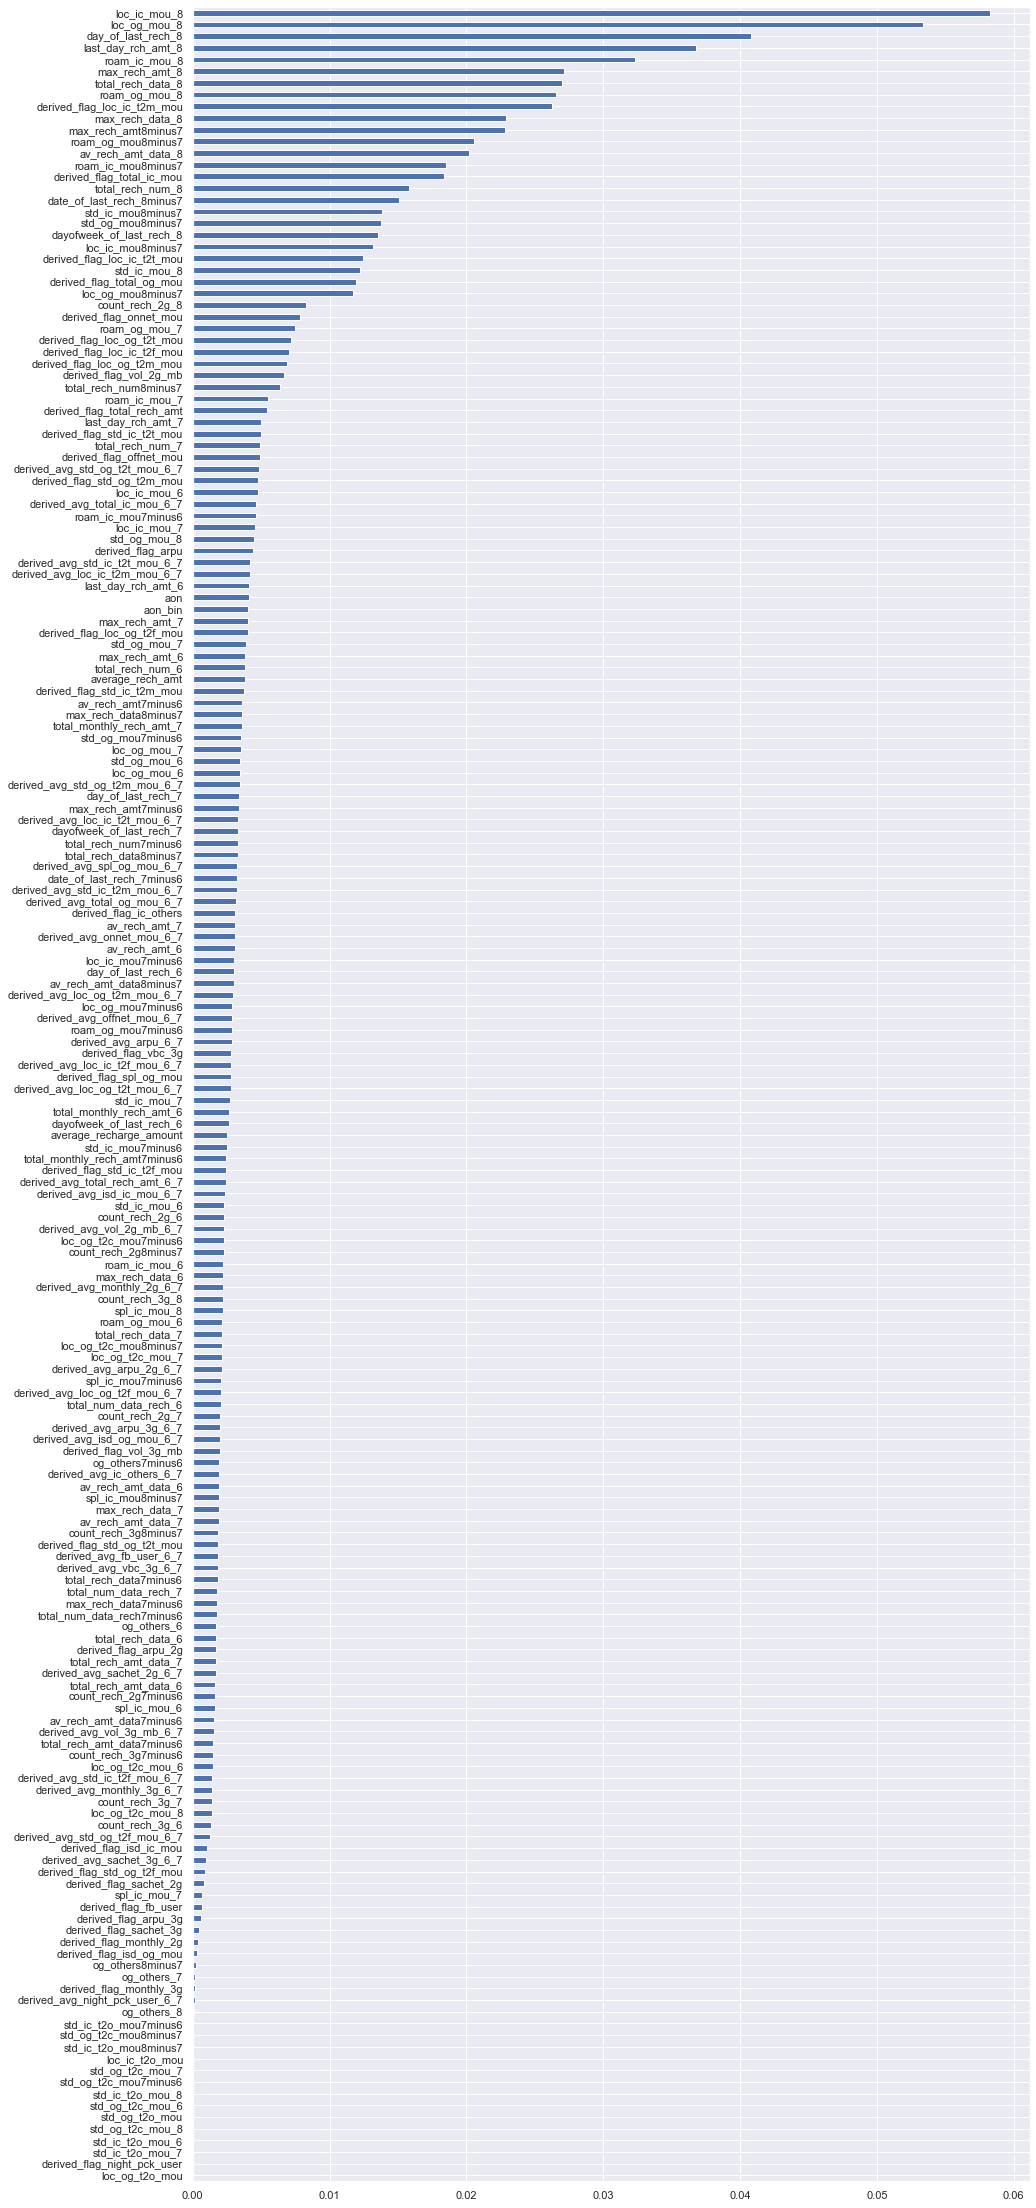

In [244]:
# Plot the feature importance to get the top features
plt.figure(figsize=(15,40))
feature_importances.iloc[:,0].nlargest(len(X_train.columns)).sort_values().plot(kind='barh', align='center')

Some of the top main predictiors of churn are the monthly KPI features for the action phase i.e 3rd month (August). The graph suggests the top features based on their importance. Hence action phase KPIs have a direct impact on the churn behavior of high value customers.

- Local incoming or outgoing calls MOUs (Minutes of usage) have a very important role for churn predictions. Reduced values of this KPI gives a clear indication of high value customers inclining towards churn behaviour.
- Drop in these above indicators give a signal that customer is not happy with services provided by the telecom company and might churn in near future.

### Recommendation of strategies to manage customer churn

#### 1. Monitoring Drop in usage

Based on the observations in exploratory data analysis and model performance, customer churn seems to be well predicted by drop in usage of various services.

Apart from the automated recommendations engine based on machine learning algorithms, the telecom company should also pay attention to drop in MOU (Minutes of usage), ARPU (Average Revenue generated per user) and 2G/3G data usage month over month. The company should have mechanisms to track these figures every week and it will help to telecom company to predict the possible customers who may churn in near future. 

Company should get in touch with these customers proactively and immediately to find out what's affecting their experience. They should try to resolve their complains, if any, offer them discount vouchers/coupons or other incentives to continue using the services. The feedback provided by such customers should be dealt seriously because soon many other customers might also have such problems.

Marketing team must come up with campaigns which targets these high value customer who are predicted to churn in near future

#### 2. Improving outgoing call services

,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_status,,,
0,594.414582,629.096568,582.380539
1,795.591038,631.859433,210.659326


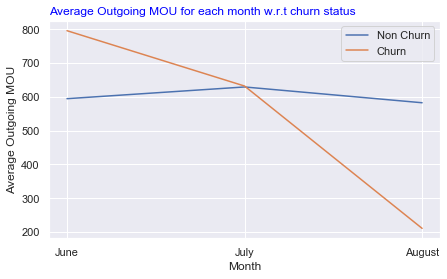

In [245]:
# total_og_mou: Total outgoing minutes of usage
to_analyse_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'churn_status']
make_variation_plot(telecom_data_backup[to_analyse_cols],to_analyse_cols[:-1], 'Outgoing MOU')
telecom_data_backup.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

We observe that initially the high value customers who churned were using more outgoing calls, but suddenly their outgoing usage dropped. It may be because they didn't like something. Reasons may be:
- Network coverage problem in outgoing services offered
- May be due to high tariffs
- Problem with overall outgoing call quality, or
- Frequent call drop problems

Stratergic recommendations are the following:
- The service provider must investigate their outgoing networks, tariffs, plans and campaigns.
- Might be that the outgoing tariffs offered to customer are not competitive compared to outgoing tariffs of their competitor network providers.
- New campaigns which targets these high value customers with high outgoing usage be rolled out, for e.g: 
    - Discounted outgoing rates during particular hours of the day for these customers.
    - For every X MOU (minutes of usage), offer customer with some free MOU schemes.
    - Perform analysis and if required make the outgoing tarrifs more competitive.

#### 3. Improving roaming call services

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8
churn_status,,,
0,14.993915,11.124666,11.217856
1,29.217630,30.163660,27.447610


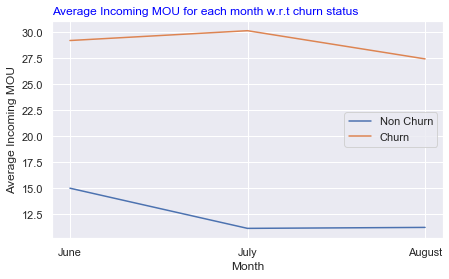

In [246]:
# roam_ic_mou: Roaming Incoming Minutes of Usage
to_analyse_cols = ['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'churn_status']
make_variation_plot(telecom_data_backup[to_analyse_cols],to_analyse_cols[:-1], 'Incoming MOU')
telecom_data_backup.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
churn_status,,,
0,24.366118,17.518635,17.798878
1,52.286526,50.488313,43.996013


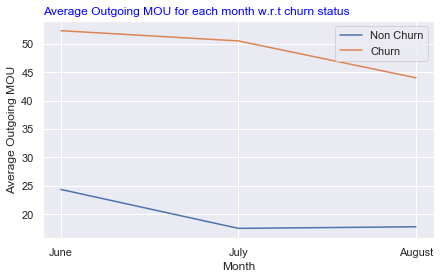

In [247]:
# roam_og_mou: Roaming Outgoing Minutes of Usage
to_analyse_cols = ['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'churn_status']
make_variation_plot(telecom_data_backup[to_analyse_cols],to_analyse_cols[:-1], 'Outgoing MOU')
telecom_data_backup.groupby(['churn_status'])[to_analyse_cols[:-1]].mean()

We observe that overall the high value customers who churned are always using more roaming call facility i.e. both incoming and outgoing, so it's always better to maintain the highest standards in roaming network and services.

Stratergic recommendations are the following:
- Churners show higher roaming usage than non-churners.
- The service providers must investigate their network and service quality along with roaming tariff.
- Might be possible that the roaming tariffs offered are less competitive than their competitors.
- It might be that the customer is not getting good quality of service while roaming.
- New campaigns which targets the roaming customers can be rolled out, for e.g:
    - Discounted roaming rates during particular hours of the day for these high value customers.
    - Schemes giving free monthly roaming MOU (minutes of usage) depending on the users past roaming usage.